# Costa Rican Household Poverty Level Prediction

Costa Rican Household Poverty Level Prediction is a Kaggle competition which is currently open for late submissions. This competition is for a social cause to help Inter-American Development Bank to identify which households have the highest need for social welfare assistance. Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify. Other than Costa Rica, many other countries also face this same problem of inaccurately assessing social need. If data scientists can generate an improvement, many countries can take benefit out of it.

The dataset available in Kaggle is a set of household characteristics from a representative sample of Costa Rican Households. The dataset has observations for each member of the household but the classification is done at the household level. This is a multi-class classification problem using a supervised machine learning approach. We classify households according to their income levels (1 = extreme poverty,  2 = moderate poverty, 3 = vulnerable households, 4 = non-vulnerable households). We have identified the multiclass classification algorithms which we think apt to use for this type of problems like, KNN, Logistic Regression, Naive Bayes, Random Forest etc. We will fine-tune the hyperparameters for each model and evaluate the different models using f1-score and accuracy metrics to find out the top best among them. Will do significance tests to figure out the optimal model to perform prediction.

Kaggle competition link:

https://www.kaggle.com/c/costa-rican-household-poverty-prediction (Links to an external site.)Links to an external site.
  

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline.

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
# imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Imports for metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Imports for stats
from scipy import stats
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Train Accuracy (Mean)", "Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Set up ShuffleSplit for p_value testing
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

# Download the data

Data can be downloaded from this link:
    
https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data   

The data is located locally within this folder. 

In [5]:
%ls -l all/train.csv

-rw-rw-r-- 1 1000 1000 3237288 Nov 14 17:32 all/train.csv


In [6]:
import pandas as pd

In [7]:
full_train_data = pd.read_csv('all/train.csv')

In [8]:
train_data = pd.read_csv('all/train.csv')
test_data = pd.read_csv('all/test.csv')

# Dataset Description

**File descriptions**
{train|test}.csv - the training set

This is the main table, broken into two files for Train (with a Target column) and Test (without the Target column).
One row represents one person in our data sample.
Multiple people can be part of a single household. Only predictions for heads of household are scored.
sample_submission.csv - a sample submission file in the correct format

This file contains all test IDs and a default value.
Note that ONLY the heads of household are used in scoring. All household members are included in test + the sample submission, but only heads of households are scored.

The file is a set of household characteristics from a representative sample of Costa Rican Households. The dataset has observations for each member of the household but the classification is done at the household level. That is, households cannot have two different classifications. Data is not presented at the household level so that Data Scientists can create their own household features from individual data.


**Core Data fields**
- Id - a unique identifier for each row.
- Target - the target is an ordinal variable indicating groups of income levels.
        1 = extreme poverty 
        2 = moderate poverty 
        3 = vulnerable households 
        4 = non vulnerable households
- idhogar - this is a unique identifier for each household. This can be used to create household-wide features, etc. All rows in a given household will have a matching value for this identifier.
- parentesco1 - indicates if this person is the head of the household.
- This data contains 142 total columns.


**All Data fields**

**Variable name, Variable description**

- v2a1, Monthly rent payment
- hacdor, =1 Overcrowding by bedrooms
- rooms,  number of all rooms in the house
- hacapo, =1 Overcrowding by rooms
- v14a, =1 has bathroom in the household
- refrig, =1 if the household has refrigerator
- v18q, owns a tablet
- v18q1, number of tablets household owns
- r4h1, Males younger than 12 years of age
- r4h2, Males 12 years of age and older
- r4h3, Total males in the household
- r4m1, Females younger than 12 years of age
- r4m2, Females 12 years of age and older
- r4m3, Total females in the household
- r4t1, persons younger than 12 years of age
- r4t2, persons 12 years of age and older
- r4t3, Total persons in the household
- tamhog, size of the household
- tamviv, number of persons living in the household
- escolari, years of schooling
- rez_esc, Years behind in school
- hhsize, household size
- paredblolad, =1 if predominant material on the outside wall is block or brick
- paredzocalo, "=1 if predominant material on the outside wall is socket (wood,  zinc or absbesto"
- paredpreb, =1 if predominant material on the outside wall is prefabricated or cement
- pareddes, =1 if predominant material on the outside wall is waste material
- paredmad, =1 if predominant material on the outside wall is wood
- paredzinc, =1 if predominant material on the outside wall is zink
- paredfibras, =1 if predominant material on the outside wall is natural fibers
- paredother, =1 if predominant material on the outside wall is other
- pisomoscer, "=1 if predominant material on the floor is mosaic,  ceramic,  terrazo"
- pisocemento, =1 if predominant material on the floor is cement
- pisoother, =1 if predominant material on the floor is other
- pisonatur, =1 if predominant material on the floor is  natural material
- pisonotiene, =1 if no floor at the household
- pisomadera, =1 if predominant material on the floor is wood
- techozinc, =1 if predominant material on the roof is metal foil or zink
- techoentrepiso, "=1 if predominant material on the roof is fiber cement,  mezzanine "
- techocane, =1 if predominant material on the roof is natural fibers
- techootro, =1 if predominant material on the roof is other
- cielorazo, =1 if the house has ceiling
- abastaguadentro, =1 if water provision inside the dwelling
- abastaguafuera, =1 if water provision outside the dwelling
- abastaguano, =1 if no water provision
- public, "=1 electricity from CNFL,  ICE,  ESPH/JASEC"
- planpri, =1 electricity from private plant
- noelec, =1 no electricity in the dwelling
- coopele, =1 electricity from cooperative
- sanitario1, =1 no toilet in the dwelling
- sanitario2, =1 toilet connected to sewer or cesspool
- sanitario3, =1 toilet connected to  septic tank
- sanitario5, =1 toilet connected to black hole or letrine
- sanitario6, =1 toilet connected to other system
- energcocinar1, =1 no main source of energy used for cooking (no kitchen)
- energcocinar2, =1 main source of energy used for cooking electricity
- energcocinar3, =1 main source of energy used for cooking gas
- energcocinar4, =1 main source of energy used for cooking wood charcoal
- elimbasu1, =1 if rubbish disposal mainly by tanker truck
- elimbasu2, =1 if rubbish disposal mainly by botan hollow or buried
- elimbasu3, =1 if rubbish disposal mainly by burning
- elimbasu4, =1 if rubbish disposal mainly by throwing in an unoccupied space
- elimbasu5, "=1 if rubbish disposal mainly by throwing in river,  creek or sea"
- elimbasu6, =1 if rubbish disposal mainly other
- epared1, =1 if walls are bad
- epared2, =1 if walls are regular
- epared3, =1 if walls are good
- etecho1, =1 if roof are bad
- etecho2, =1 if roof are regular
- etecho3, =1 if roof are good
- eviv1, =1 if floor are bad
- eviv2, =1 if floor are regular
- eviv3, =1 if floor are good
- dis, =1 if disable person
- male, =1 if male
- female, =1 if female
- estadocivil1, =1 if less than 10 years old
- estadocivil2, =1 if free or coupled uunion
- estadocivil3, =1 if married
- estadocivil4, =1 if divorced
- estadocivil5, =1 if separated
- estadocivil6, =1 if widow/er
- estadocivil7, =1 if single
- parentesco1, =1 if household head
- parentesco2, =1 if spouse/partner
- parentesco3, =1 if son/doughter
- parentesco4, =1 if stepson/doughter
- parentesco5, =1 if son/doughter in law
- parentesco6, =1 if grandson/doughter
- parentesco7, =1 if mother/father
- parentesco8, =1 if father/mother in law
- parentesco9, =1 if brother/sister
- parentesco10, =1 if brother/sister in law
- parentesco11, =1 if other family member
- parentesco12, =1 if other non family member
- idhogar, Household level identifier
- hogar_nin, Number of children 0 to 19 in household
- hogar_adul, Number of adults in household
- hogar_mayor, # of individuals 65+ in the household
- hogar_total, # of total individuals in the household
- dependency, Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
- edjefe, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- meaneduc,average years of education for adults (18+)
- instlevel1, =1 no level of education
- instlevel2, =1 incomplete primary
- instlevel3, =1 complete primary
- instlevel4, =1 incomplete academic secondary level
- instlevel5, =1 complete academic secondary level
- instlevel6, =1 incomplete technical secondary level
- instlevel7, =1 complete technical secondary level
- instlevel8, =1 undergraduate and higher education
- instlevel9, =1 postgraduate higher education
- bedrooms, number of bedrooms
- overcrowding, # persons per room
- tipovivi1, =1 own and fully paid house
- tipovivi2, "=1 own,  paying in installments"
- tipovivi3, =1 rented
- tipovivi4, =1 precarious
- tipovivi5, "=1 other(assigned,  borrowed)"
- computer, =1 if the household has notebook or desktop computer
- television, =1 if the household has TV
- mobilephone, =1 if mobile phone
- qmobilephone, # of mobile phones
- lugar1, =1 region Central
- lugar2, =1 region Chorotega
- lugar3, =1 region PacÃƒÂ­fico central
- lugar4, =1 region Brunca
- lugar5, =1 region Huetar AtlÃƒÂ¡ntica
- lugar6, =1 region Huetar Norte
- area1, =1 zona urbana
- area2, =2 zona rural
- age, Age in years
- SQBescolari, escolari squared
- SQBage, age squared
- SQBhogar_total, hogar_total squared
- SQBedjefe, edjefe squared
- SQBhogar_nin, hogar_nin squared
- SQBovercrowding, overcrowding squared
- SQBdependency, dependency squared
- SQBmeaned, square of the mean years of education of adults (>=18) in the household
- agesq, Age squared

# Exploratory Data Analysis

## Training dataset

Lets analyze the training dataset

In [9]:
train_data.shape

(9557, 143)

Train data set have 143 columns and 9557 rows of data

In [10]:
pd.options.display.max_columns = 150
train_data.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


This gives a complete feature columns information which is quite difficult to understand. Lets see an brief overview on the data

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


Allright. We do have some information here. There are total of 143 columns consisting of 8 float columns, 130 integer columns and 5 object columns. For the features to be fed into machine learning model, a feature engineering is required to analyze these columns and fix them.

Integer columns might consists of Boolean variables(0 or 1) and discrete variables. 
Object columns needs further study to check if they can be converted into numerical values to fit into machine learning model. 

In [12]:
train_data.dtypes

Id                  object
v2a1               float64
hacdor               int64
rooms                int64
hacapo               int64
v14a                 int64
refrig               int64
v18q                 int64
v18q1              float64
r4h1                 int64
r4h2                 int64
r4h3                 int64
r4m1                 int64
r4m2                 int64
r4m3                 int64
r4t1                 int64
r4t2                 int64
r4t3                 int64
tamhog               int64
tamviv               int64
escolari             int64
rez_esc            float64
hhsize               int64
paredblolad          int64
paredzocalo          int64
paredpreb            int64
pareddes             int64
paredmad             int64
paredzinc            int64
paredfibras          int64
                    ...   
bedrooms             int64
overcrowding       float64
tipovivi1            int64
tipovivi2            int64
tipovivi3            int64
tipovivi4            int64
t

In [13]:
train_data.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,1629.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.00000,9557.000000,9557.000000,9557.0,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.00000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,1.945066,0.399184,1.661714,2.060898,0.785079,3.220885,4.005964,3.999058,4.094590,7.200272,0.459791,3.999058,0.594015,0.077744,0.188030,0.008580,0.115622,0.013079,0.001465,0.001465,0.692791,0.222873,0.000942,0.001046,0.016428,0.065920,0.970074,0.017683,0.003139,0.002197,0.677409,0.964738,0.031705,0.003558,0.885110,0.000314,0.002197,0.110809,0.003872,0.213979,0.764257,0.015381,0.002511,0.001883,0.489589,0.458407,0.050120,0.882704,0.03003,0.084545,0.001465,0.0,0.001256,0.102438,0.327404,0.570158,0.128388,0.288061,0.583551,0.101078,0.252799,0.646123,0.057549,0.483415,0.516585,0.137805,0.123260,0.268390,0.031914,0.062781,0.033169,0.342681,0.311081,0.184054,0.381814,0.012138,0.009522,0.051167,0.010045,0.002407,0.013289,0.003139,0.012661,0.008685,1.406613,2.592445,0.284085,3.999058,9.231523,0.134666,0.170556,0.207701,0.185414,0.112692,0.017893,0.015591,0.139793,0.015381,2.739981,1.605380,0.61850,0.1

In [14]:
train_data.corr()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
v2a1,1.000000,-0.091732,0.443461,-0.073509,0.033551,0.088970,0.278364,0.302292,-0.081900,-0.002401,-0.059548,-0.072791,0.048169,-0.007806,-0.103959,0.032631,-0.043574,-0.064566,-0.051396,0.288006,-0.086238,-0.064566,0.290062,-0.101152,-0.174037,-0.037311,-0.134678,-0.053664,-0.025562,-0.015824,0.296623,-0.273600,NaN,NaN,-0.031581,-0.085837,-0.001022,0.011072,-0.029893,NaN,0.300238,0.055717,-0.055717,NaN,0.121159,NaN,NaN,-0.121159,-0.027800,0.141261,-0.132268,-0.035019,-0.023344,-0.017993,0.247867,-0.238980,-0.051818,0.122205,-0.066894,-0.093337,-0.041608,NaN,NaN,-0.129924,-0.242453,0.298101,-0.081504,-0.187258,0.221301,-0.124955,-0.202315,0.254528,-0.009161,-0.016410,0.016410,-0.044223,-0.072324,0.132792,0.038230,-0.061174,-0.026920,-0.007141,0.015678,0.042345,-0.010566,-0.059103,-0.028405,-0.058510,0.020017,-0.005813,-0.009135,0.024459,-0.004790,0.004421,-0.113882,0.048189,-0.036530,-0.064566,0.426544,-0.052032,-0.105092,-0.106630,-0.098785,-0.027489,-0.001094,0.023615,0.289269,0.227575,0.297657,-0.233023,NaN,0.226177,-0.226177,NaN,NaN,0.272942,0.041303,0.065360,0.108504,0.231539,-0.019377,-0.039030,-0.121150,-0.128111,-0.143357,0.112759,-0.112759,0.078897,0.358305,0.062343,-0.061309,0.364290,-0.082246,-0.191915,-0.061352,0.402561,0.062343,0.273559
hacdor,-0.091732,1.000000,-0.233369,0.652594,-0.175011,-0.101965,-0.084680,-0.049262,0.232508,0.059313,0.184857,0.268978,0.142458,0.264620,0.328901,0.134909,0.304282,0.304884,0.350948,-0.122134,0.047466,0.304884,-0.136055,0.074927,-0.027202,0.147449,0.083620,0.155120,-0.007622,-0.007622,-0.168472,0.077334,-0.006109,0.078103,0.232319,0.055087,-0.042053,-0.026698,-0.011166,-0.009338,-0.177257,-0.053838,0.060714,-0.011890,0.018548,-0.003526,-0.009338,-0.016256,0.102032,-0.018513,0.011347,-0.024871,-0.009984,-0.008644,-0.074592,0.052816,0.052003,-0.039592,-0.002982,0.049567,-0.007622,NaN,-0.007055,0.186977,0.053383,-0.165127,0.150780,0.046047,-0.144617,0.248834,0.035195,-0.188850,-0.013962,-0.010899,0.010899,0.101245,0.048446,-0.083512,-0.036129,-0.004175,-0.024646,-0.004303,-0.059319,-0.035260,0.014650,0.052828,0.019894,0.095210,-0.003598,-0.009773,-0.003996,-0.001394,0.031250,0.034400,0.316924,0.092055,-0.047062,0.304884,-0.108783,0.084845,0.043483,0.001882,-0.003503,-0.043254,-0.018611,-0.007391,-0.070758,-0.024871,-0.209735,0.670727,-0.063173,-0.066533,0.073560,0.151115,0.010075,-0.067109,-0.075837,-0.059923,0.004046,-0.042086,0.017444,0.025546,-0.010172,0.037182,0.005289,0.027721,-0.027721,-0.118168,-0.109862,-0.102725,0.350546,-0.082229,0.388043,0.794699,0.005278,-0.099153,-0.102725,-0.191714
rooms,0.443461,-0.233369,1.000000,-0.213368,0.129183,0.130531,0.254256,0.2

In [15]:
#Lets find the targetted features from the train and test data. 
print("Features to predict: ", set(train_data.columns) - set(test_data.columns))

Features to predict:  {'Target'}


In [16]:
train_data['Target'].describe()

count    9557.000000
mean        3.302292
std         1.009565
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: Target, dtype: float64

According to the Kaggle description, we have to predict the income qualification for some of the world's poorest families. Meaning, to predict the poverty level of the households. But from the feature study, most of the characteristic features are defined as individual level rather than the household.

It is better to study the person who is leading the household to find the poverty levels rather than studying each individual in the household. 

From the data description variables, the feature **parentesco1** represents to the head of the household.

Let us analyse train data and clean up the data for data modelling.

### Number of Null Columns.

In [17]:
pd.options.display.max_rows = 150
missing= train_data.isnull().sum()
missing[missing!=0]

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64

In [18]:
missing_data=pd.DataFrame(missing[missing!=0].rename('Missing data'))
missing_data['Total rows in dataset'] = len(train_data)
missing_data['Percentage of missing data'] = missing[missing!=0]/len(train_data)


In [19]:
missing_data

,Missing data,Total rows in dataset,Percentage of missing data
v2a1,6860,9557,0.717798
v18q1,7342,9557,0.768233
rez_esc,7928,9557,0.829549
meaneduc,5,9557,0.000523
SQBmeaned,5,9557,0.000523


The three columns v2a1, v18q1 and rez_esc needs to be handled closely as they constitute more than 75% of the corresponding column data is empty or missing. We will address these 3 features to fit in the best possible data for missing values.

### Object columns

In [20]:
train_data.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


The Id and idhogar are identifying variables. Values of other columns are a mix of numbers and strings. Mostly we see yes and no string variables in dependency, edjefe and edjefa. Converting all yes and no variables into the numerical values will convert the feature datatypes into integers which can feed to machine learning algorithms.

### Target Value counts

In [21]:
def barchart(povlevel, y_values, plot_space=plt, anno_vals=None):
    pov_lvl = np.arange(len(povlevel))
    plot_space.bar(pov_lvl, y_values)
    plot_space.xticks(pov_lvl, povlevel, rotation=270)
    if anno_vals == None:
        anno_vals = y_values
    for i in range(len(povlevel)):
        plot_space.text(x=pov_lvl[i]-0.3, y=y_values[i]+1.0, s=anno_vals[i])

**Target values defined for the head of the households**

In [22]:
train_data_heads = train_data.loc[train_data['parentesco1'] == 1]
poverty_label_sizes = list(train_data_heads.groupby('Target').size())
total_poverty_label = list(train_data.groupby('Target').size())

### Visualization

**Targets defined for individual in the household**

Text(0,0.5,'Number of people')

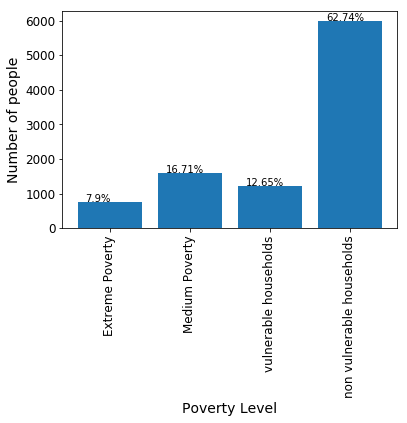

In [23]:
values = ["Extreme Poverty", "Medium Poverty", "vulnerable households", "non vulnerable households"]
barchart(values, total_poverty_label,
                     anno_vals = [str(round((count/train_data.shape[0])*100, 2))+'%' 
                                      for count in total_poverty_label])
plt.rcParams["figure.figsize"] = [6, 6]
plt.xlabel('Poverty Level')
plt.xticks([0,1,2,3],values, rotation=90)
plt.ylabel('Number of people')

**Targets defined for the head of the households**

Text(0,0.5,'Number of heads in household')

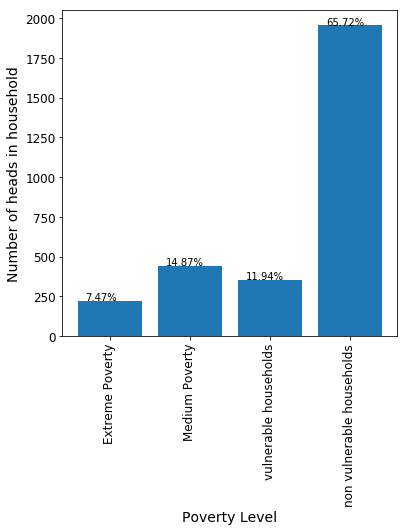

In [24]:
barchart(values, poverty_label_sizes,
                     anno_vals = [str(round((count/train_data_heads.shape[0])*100, 2))+'%' 
                                      for count in poverty_label_sizes])
plt.rcParams["figure.figsize"] = [6, 6]
plt.xlabel('Poverty Level')
plt.xticks([0,1,2,3],values, rotation=90)
plt.ylabel('Number of heads in household')

### Redundant Household Variables 

Let's analyse the redundant household variables and see how they are effecting the poverty levels of different households.

In [25]:
def plot_properties(prop_dataframe):
    _, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(16, 16))
 
    target_index = 0
    for row in range(2):
        for col in range(2):
            percentlist = [round((count/poverty_label_sizes[target_index])*100, 2)
                                 for count in list(prop_dataframe.iloc[target_index, :])]
            pov_lvl = list(range(len(prop_dataframe.columns)))
            
            axarr[row, col].bar(pov_lvl, percentlist, color='y')
            
            axarr[0, 0].set_title('Extremely Poverty - Target Group:' + str(target_index-2))
            axarr[0, 1].set_title('Medium Poverty - Target Group:' + str(target_index-1))
            axarr[1, 0].set_title('Vulnerable Households - Target Group:' + str(target_index))
            axarr[1, 1].set_title('Non-Vulnerable Households - Target Group:' + str(target_index+1))
            
            xtick_labels = list(prop_dataframe.columns)
            
            
            axarr[row,col].set_xticks(pov_lvl)
            #xtick_labels.insert(0, '')
            axarr[row, col].set_xticklabels(xtick_labels, rotation=300);
            axarr[row, col].set_ylabel("Percentage of people");
            axarr[row, col].set_xlabel("Feature Types");
                        
            for i in range(len(prop_dataframe.columns)):
                axarr[row, col].annotate(xy=(pov_lvl[i]-0.3, percentlist[i]+1.0), s=percentlist[i]);
            axarr[row, col].autoscale(enable=True, axis='x')
            target_index+=1

#### Analyze material on the outside wall

Data description for the outside wall materials

- paredblolad, =1 if predominant material on the outside wall is block or brick
- paredzocalo, "=1 if predominant material on the outside wall is socket (wood, zinc or absbesto"
- paredpreb, =1 if predominant material on the outside wall is prefabricated or cement
- pareddes, =1 if predominant material on the outside wall is waste material
- paredmad, =1 if predominant material on the outside wall is wood
- paredzinc, =1 if predominant material on the outside wall is zink
- paredfibras, =1 if predominant material on the outside wall is natural fibers
- paredother, =1 if predominant material on the outside wall is other

In [26]:
outside_wall = train_data_heads.groupby('Target').sum()[['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 
                                  'paredzinc', 'paredfibras', 'paredother']]
outside_wall

,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother
Target,,,,,,,,
1,84,24,58,6,44,4,2,0
2,175,54,105,10,87,9,1,1
3,182,30,84,4,54,1,0,0
4,1353,123,298,5,154,16,2,3


Lets plot the above table for different poverty groups

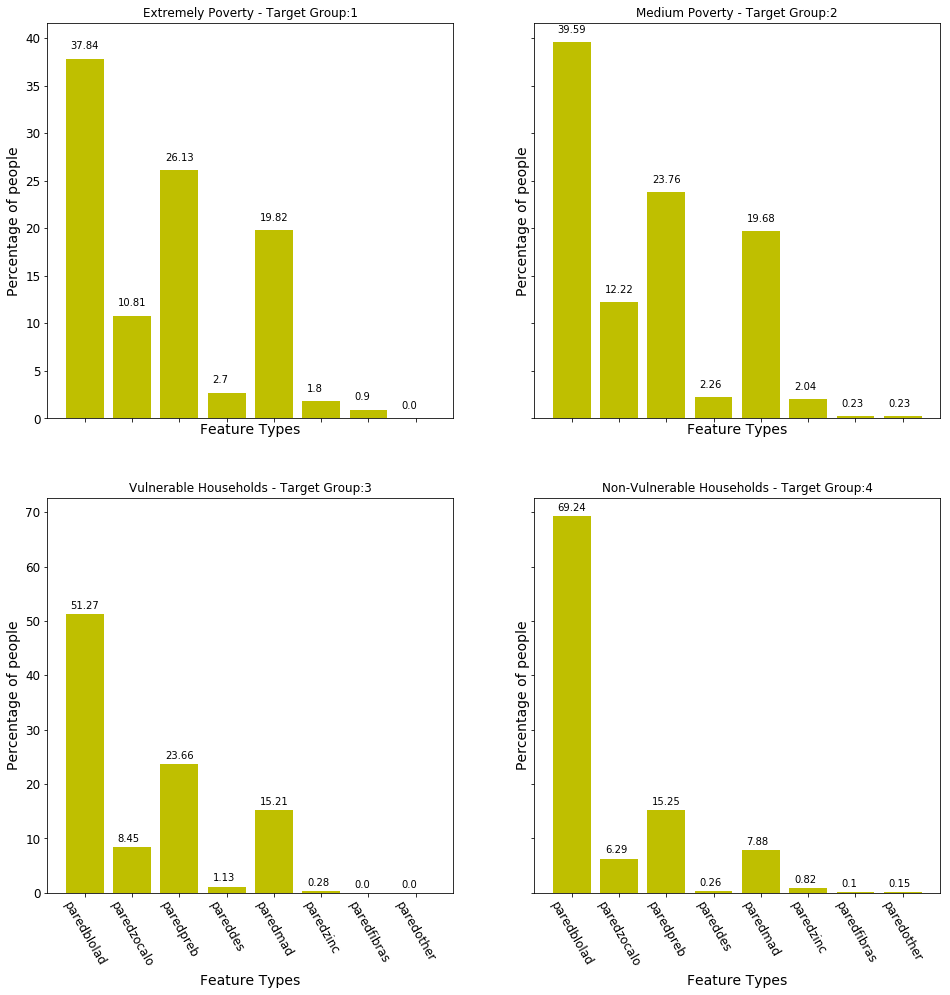

In [27]:
plot_properties(outside_wall)

From the above charts, we see that the percentage of wooden exterier walls are being reduced from extemely poverty to non-vulnerable. Also almost 70% of non-vulnarable household heads are having the houses exterier walls build with cement.

So the most commonly used walls in descending order in terms of vulnerability: wood -> prefabricated or cement -> block or bricks

Other features doesn't show much effect on the household poverty.

#### Analyze the floor material of the house 

Data description for the floor material of the house

- pisomoscer, =1 if predominant material on the floor is mosaic,  ceramic,  terrazo
- pisocemento, =1 if predominant material on the floor is cement
- pisoother, =1 if predominant material on the floor is other
- pisonatur, =1 if predominant material on the floor is  natural material
- pisonotiene, =1 if no floor at the household
- pisomadera, =1 if predominant material on the floor is wood

In [28]:
floor_material = train_data_heads.groupby('Target').sum()[['pisomoscer', 'pisocemento', 'pisoother',
                                                      'pisonatur', 'pisonotiene', 'pisomadera']]
floor_material

,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera
Target,,,,,,
1,101,89,0,1,8,23
2,226,147,0,2,16,51
3,223,96,0,0,6,30
4,1551,301,2,0,8,92


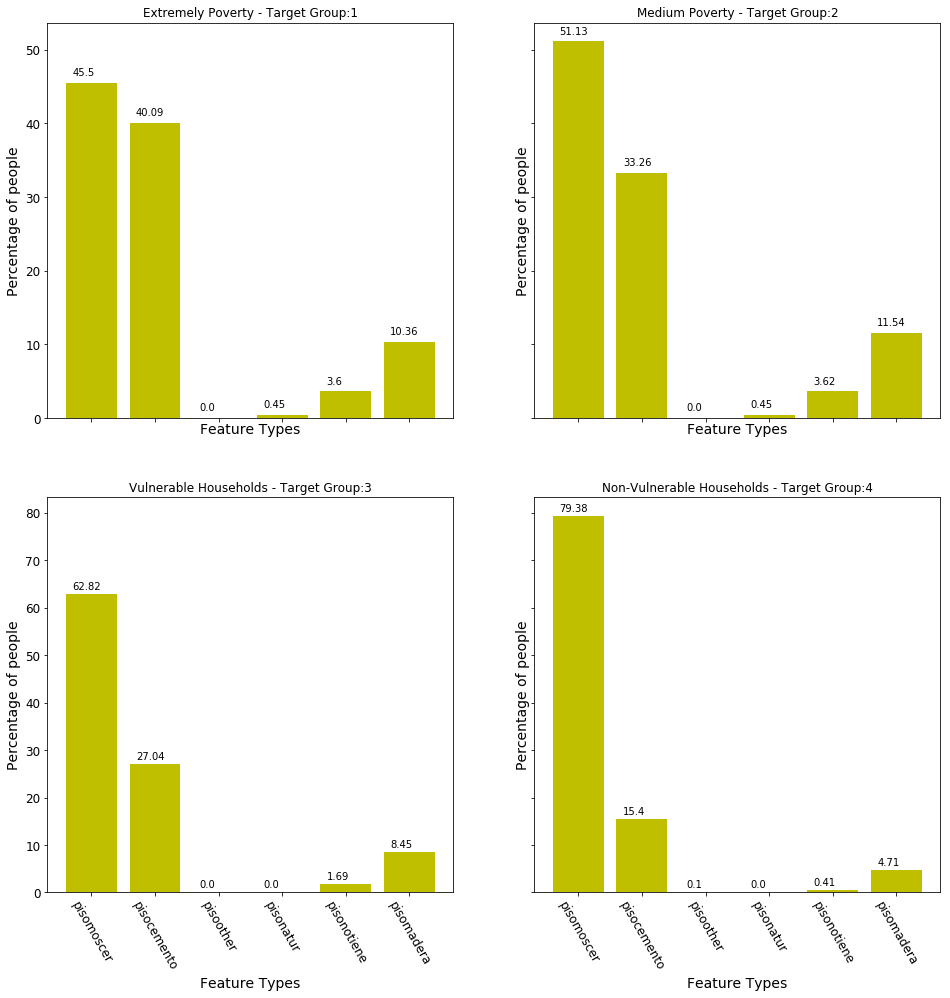

In [29]:
plot_properties(floor_material)

Non-Vulnerable and Vulnerable households are mostly using mossaic or ceramic or tazzo floors. When it comes to Extreme and Medium poverty levels, the usage of mossaic or ceramic or tazzo floors are reduced.

Most commonly used floors by the groups in terms of decreasing popularity: mossaic, ceramic, tazzo -> cement -> wood floors

#### Analyze the roof material of the house

Data description for the roof material of the house

- techozinc, =1 if predominant material on the roof is metal foil or zink
- techoentrepiso, "=1 if predominant material on the roof is fiber cement,  mezzanine "
- techocane, =1 if predominant material on the roof is natural fibers
- techootro, =1 if predominant material on the roof is other

In [30]:
roof_material = train_data_heads.groupby('Target').sum()[['techozinc', 'techoentrepiso', 'techocane', 'techootro']]
roof_material

,techozinc,techoentrepiso,techocane,techootro
Target,,,,
1,211,3,3,0
2,425,8,0,0
3,351,2,1,0
4,1887,51,5,7


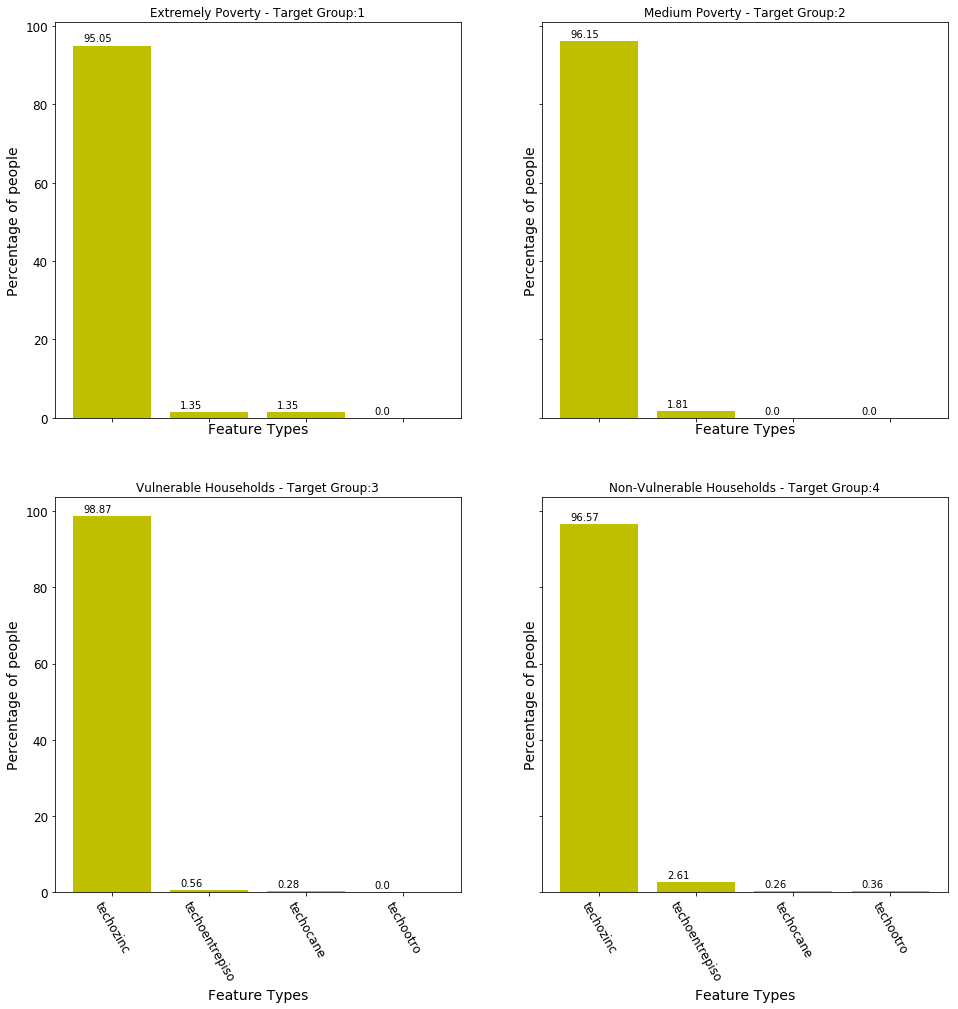

In [31]:
plot_properties(roof_material)

**These features can be discarded as we see from all the groups, >95% of all the individials from various poverty groups are living under the roof which is metal foil or zink.**

#### Analyze the Water provision

Data description for the water provision

- abastaguadentro, =1 if water provision inside the dwelling
- abastaguafuera, =1 if water provision outside the dwelling
- abastaguano, =1 if no water provision

In [32]:
water_provision = train_data_heads.groupby('Target').sum()[['abastaguadentro', 'abastaguafuera', 'abastaguano']]
water_provision

,abastaguadentro,abastaguafuera,abastaguano
Target,,,
1,212,9,1
2,416,20,6
3,342,11,2
4,1906,46,2


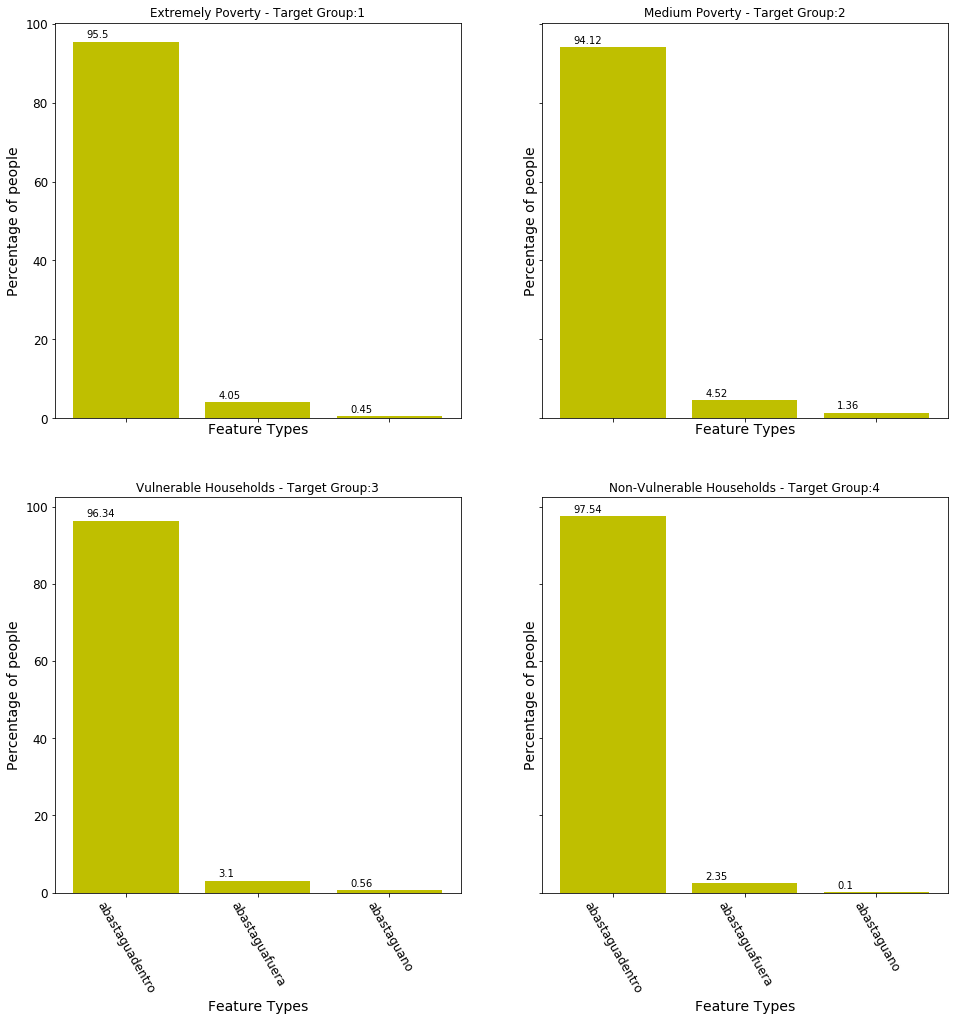

In [33]:
plot_properties(water_provision)

**We may not include these features as well as >95% of all the individuals have water provision inside the dwelling.**

#### Analyze the Electricity of the household

Data description for the electricity of household

- public, "=1 electricity from CNFL,  ICE,  ESPH/JASEC"
- planpri, =1 electricity from private plant
- noelec, =1 no electricity in the dwelling
- coopele, =1 electricity from cooperative

In [34]:
electricity = train_data_heads.groupby('Target').sum()[['public', 'planpri', 'noelec', 'coopele']]
electricity

,public,planpri,noelec,coopele
Target,,,,
1,196,0,2,23
2,385,1,4,50
3,310,0,0,45
4,1744,1,3,205


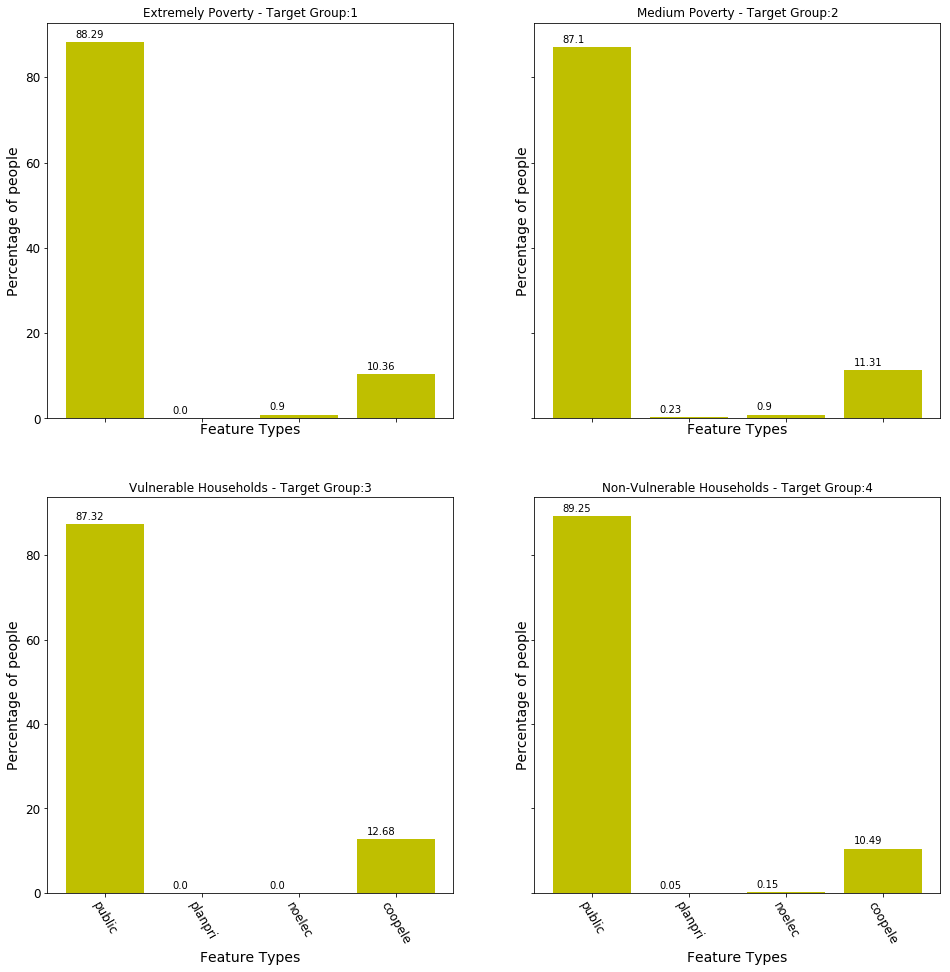

In [35]:
plot_properties(electricity)

The distribution from the four groups are pretty same. More than 87% of the individuals are getting electricity from CNFL, ICE, ESPH/JASEC. 11% are getting the electricity from the cooperative.

**These features also can be ignored as they doesnot represent the target features for measuring the poverty levels.**

#### Analyze the Toilet System

Data description for the Toilet system at the household

- sanitario1, =1 no toilet in the dwelling
- sanitario2, =1 toilet connected to sewer or cesspool
- sanitario3, =1 toilet connected to  septic tank
- sanitario5, =1 toilet connected to black hole or letrine
- sanitario6, =1 toilet connected to other system

In [36]:
toilet_system = train_data_heads.groupby('Target').sum()[['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5',
                                              'sanitario6']]
toilet_system

,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6
Target,,,,,
1,3,33,177,8,1
2,4,78,348,10,2
3,3,54,289,9,0
4,5,504,1429,12,4


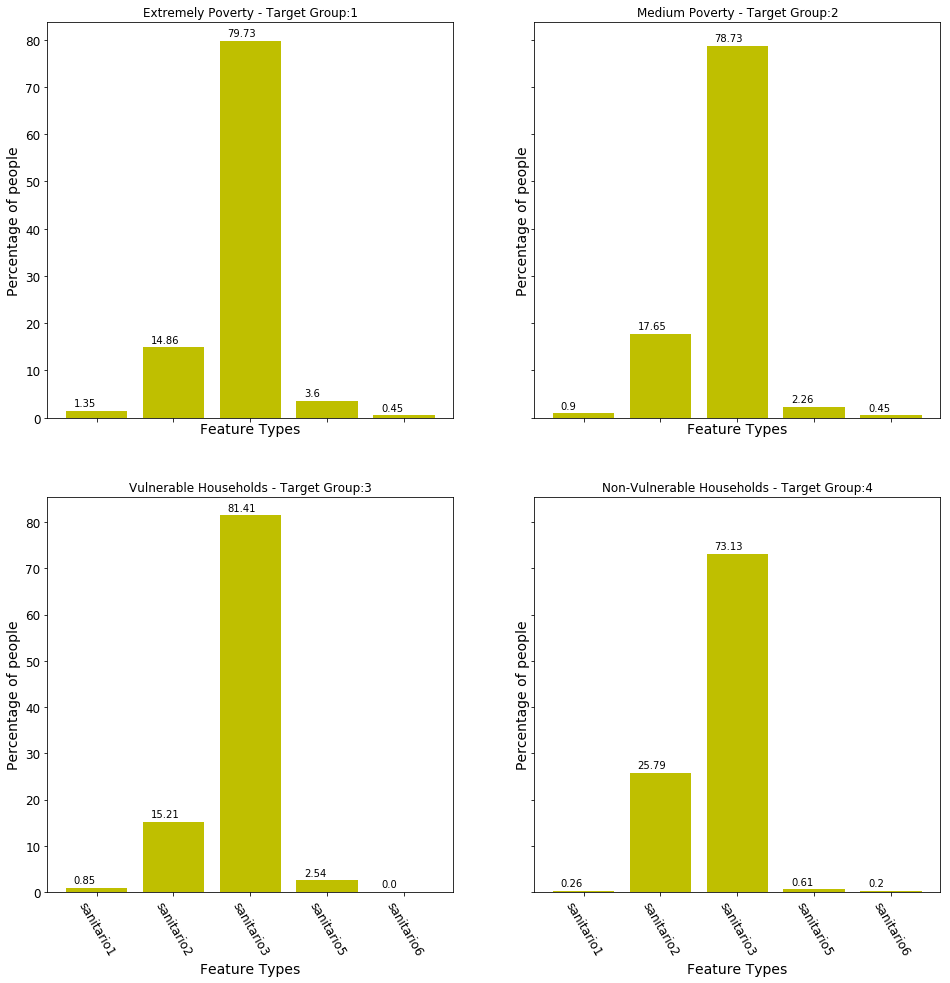

In [37]:
plot_properties(toilet_system)

On an average, most of the households are having a toilet connected to a septic tank (74%-82%)

Seeing a slight increase in the percentages for toilet connected to sewer or cesspool. Group 4 is having slightly higher percentage.

sanitario1 and sanitario6 features construct very less data. These features can be dropped from the data

#### Analyze the source of energy used for cooking

Data description for the source of energy

- energcocinar1, =1 no main source of energy used for cooking (no kitchen)
- energcocinar2, =1 main source of energy used for cooking electricity
- energcocinar3, =1 main source of energy used for cooking gas
- energcocinar4, =1 main source of energy used for cooking wood charcoal

In [38]:
cooking_energy = train_data_heads.groupby('Target').sum()[['energcocinar1', 'energcocinar2', 'energcocinar3',
                                                      'energcocinar4']]
cooking_energy

,energcocinar1,energcocinar2,energcocinar3,energcocinar4
Target,,,,
1,4,76,116,26
2,3,171,224,44
3,3,158,171,23
4,5,1095,809,45


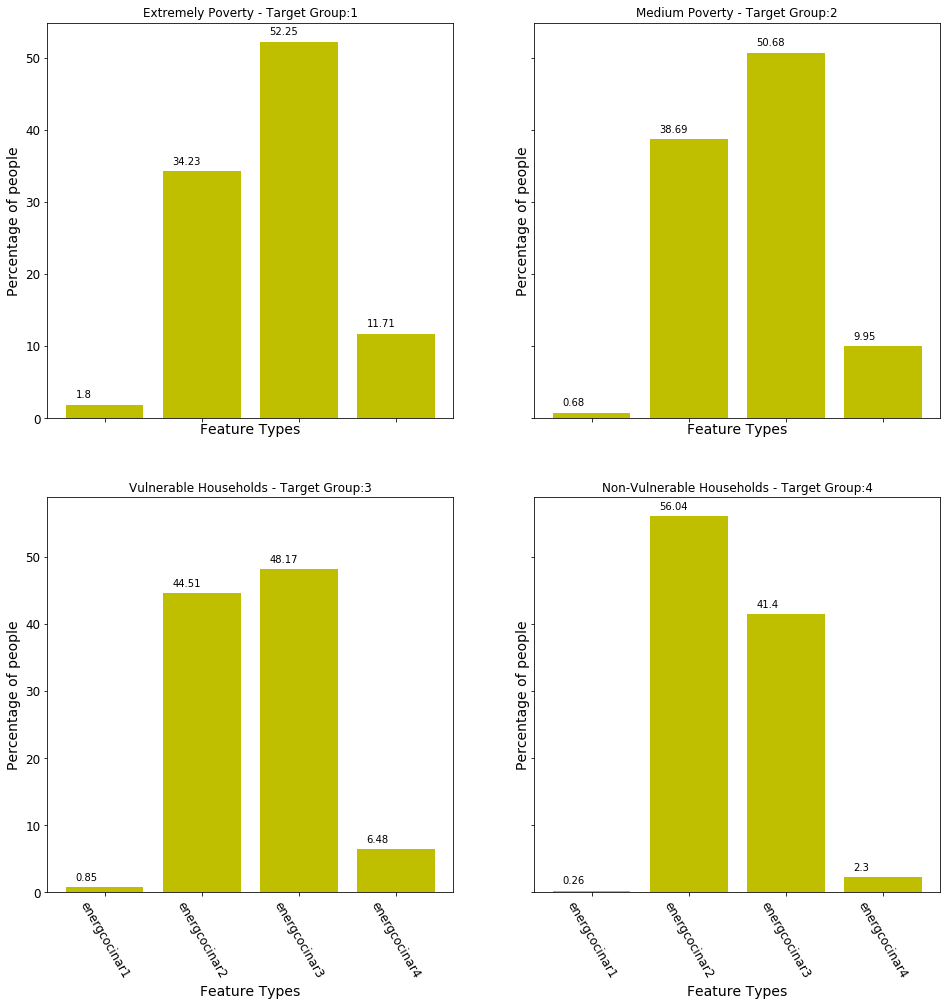

In [39]:
plot_properties(cooking_energy)

Gas and electricity are the main sources of cooking in the household.
For the non-vulnerable group, usage of electricity for cooking is slightly higher than the gas
For the Extreme poverty group, usage of gas is slightly higher than electricity.

As Poverty levels decreases (from group 1 to group4), the usage of electricity had increased and the gas had been reduced.

#### Analyze the Rubbish disposal

Data description for the rubbish disposal

- elimbasu1, =1 if rubbish disposal mainly by tanker truck
- elimbasu2, =1 if rubbish disposal mainly by botan hollow or buried
- elimbasu3, =1 if rubbish disposal mainly by burning
- elimbasu4, =1 if rubbish disposal mainly by throwing in an unoccupied space
- elimbasu5, "=1 if rubbish disposal mainly by throwing in river,  creek or sea"
- elimbasu6, =1 if rubbish disposal mainly other

In [40]:
rubbish_disposal = train_data_heads.groupby('Target').sum()[['elimbasu1', 'elimbasu2', 'elimbasu3',
                                                        'elimbasu4', 'elimbasu5', 'elimbasu6']]
rubbish_disposal

,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6
Target,,,,,,
1,178,9,35,0,0,0
2,352,24,63,3,0,0
3,300,13,41,1,0,0
4,1800,44,106,0,0,4


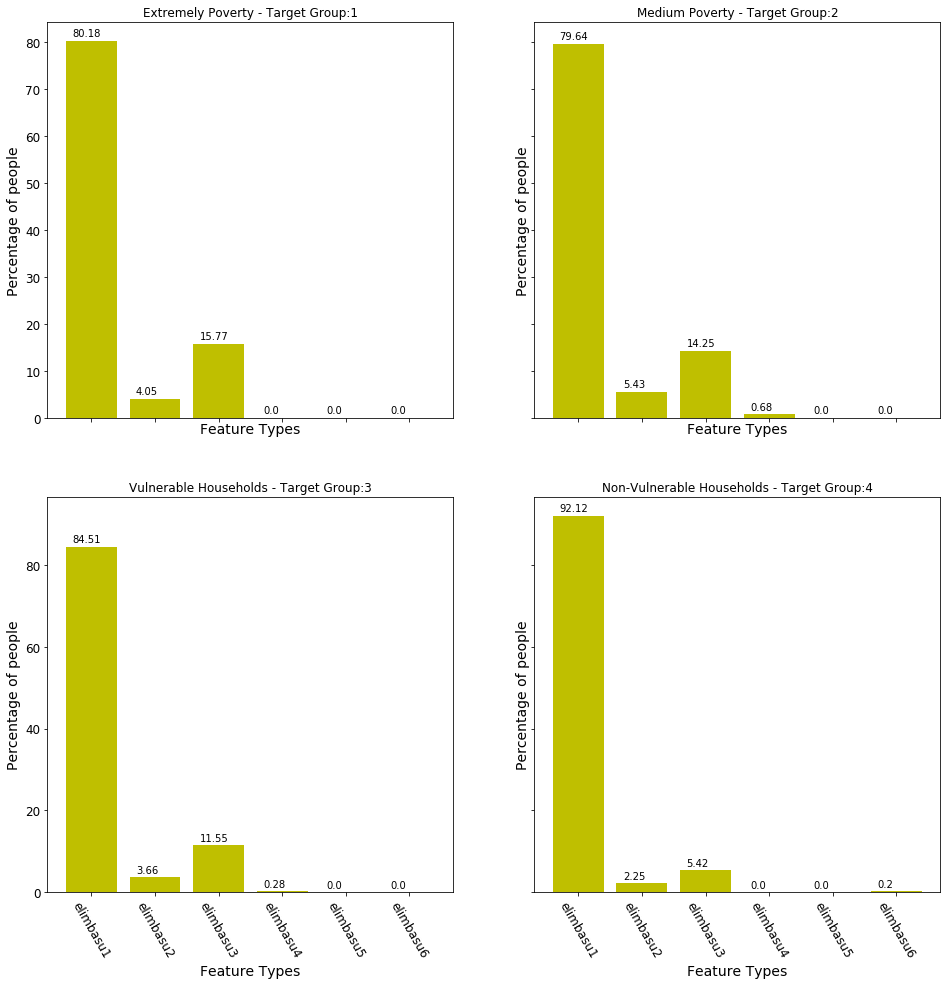

In [41]:
plot_properties(rubbish_disposal)

From the charts, >80% of the households from all the groups are disposing their rubbish using tanker truck. 

Rubbish disposal using burning had been reduced from Group1 to Group4. Individuals should get educated on disposing the rubbish properly

elimbasu4, elimbasu5, elimbasu6 doesnt construct much data and so these features can be dropped from data set

#### Analyze Household size

In [42]:
avg_household_size = train_data_heads.groupby('Target').mean()['hhsize']
avg_household_size

Target
1    3.486486
2    3.524887
3    3.383099
4    3.078813
Name: hhsize, dtype: float64

Average individuals in each household is almost similar across different target levels.

#### Analyze Urban or Rural zone

Data description for the zones

- area1, =1 zona urbana
- area2, =2 zona rural

In [43]:
urban_rural = train_data_heads.groupby('Target').sum()[['area1', 'area2']]
urban_rural['UrbanPercentage'] = urban_rural['area1'] * round((100/sum(urban_rural['area1'])), 6)
urban_rural['RuralPercentage'] = urban_rural['area2'] * round((100/sum(urban_rural['area2'])), 6)
urban_rural

,area1,area2,UrbanPercentage,RuralPercentage
Target,,,,
1,143,79,6.719856,9.349097
2,293,149,13.768656,17.633107
3,230,125,10.808160,14.792875
4,1462,492,68.702304,58.224756


The pattern resembles:

* __~ 58-69%__ of the houses are in Target group 4 (__non-vulnerable__)
* __~ 11-15%__ of the houses are in Target group 2 (__moderate poverty__)
* __~ 13-18%__ of the houses are in Target group 3 (__vulnerable__)
* __~ 6-10%__ of the houses are in Target group 1 (__extreme poverty__)

#### Analyze the Region of the households

Data description for the regions of the households

- lugar1, =1 region Central
- lugar2, =1 region Chorotega
- lugar3, =1 region PacÃƒÂ­fico central
- lugar4, =1 region Brunca
- lugar5, =1 region Huetar AtlÃƒÂ¡ntica
- lugar6, =1 region Huetar Norte

In [44]:
region_household = train_data_heads.groupby('Target').sum()[['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']]
region_household

,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6
Target,,,,,,
1,91,23,24,30,32,22
2,206,44,41,51,54,46
3,188,32,34,34,40,27
4,1272,170,97,131,149,135


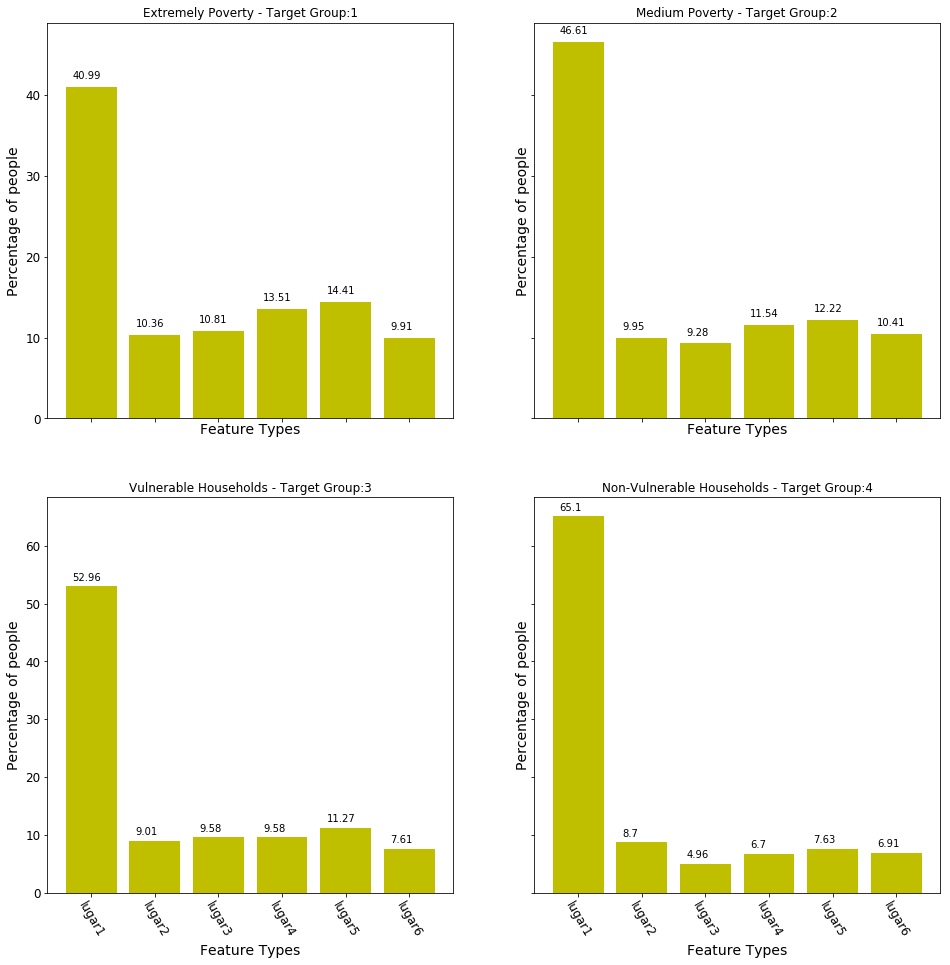

In [45]:
plot_properties(region_household)

- Most of the population from all the target groups are living in **Central** region.

#### Analyze who owns a house

Data Description 

- tipovivi1, =1 own and fully paid house
- tipovivi2, =1 own,  paying in installments
- tipovivi3, =1 rented
- tipovivi4, =1 precarious
- tipovivi5, =1 other(assigned,  borrowed)

In [46]:
own_household = train_data_heads.groupby('Target').sum()[['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']]
own_household

,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5
Target,,,,,
1,142,7,35,10,28
2,280,13,73,15,61
3,235,20,56,9,35
4,1199,240,373,12,130


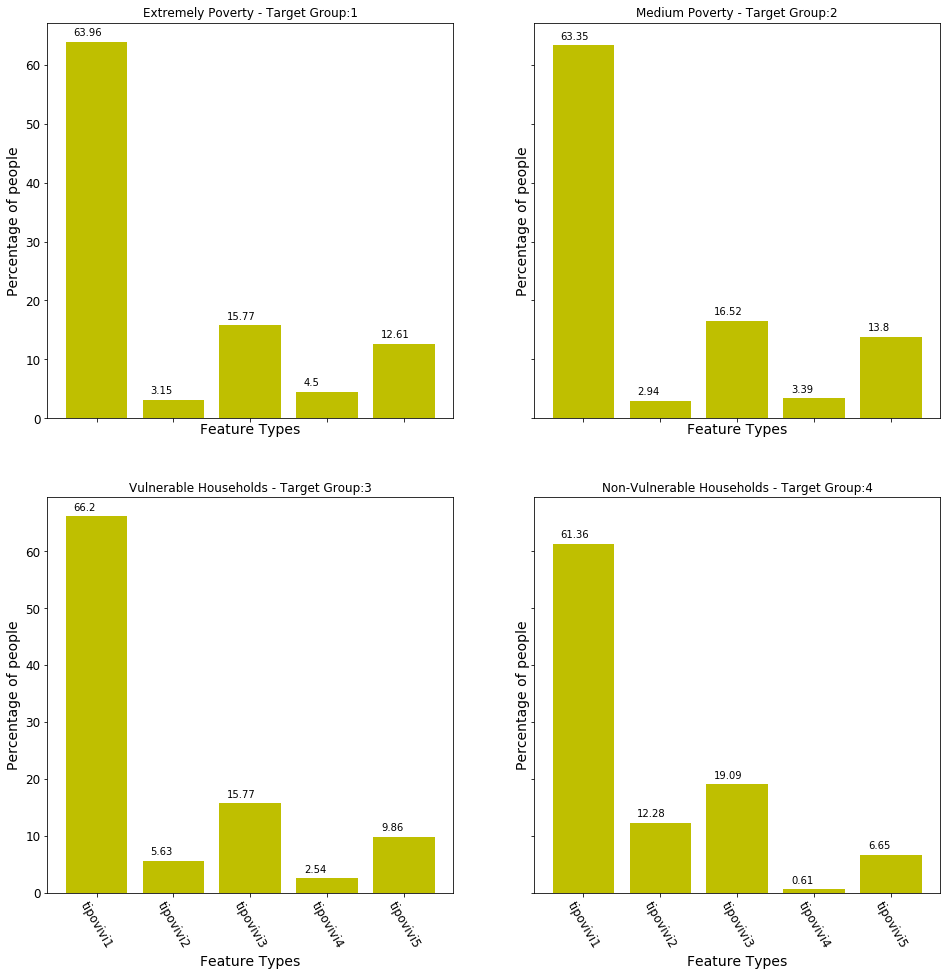

In [47]:
plot_properties(own_household)

- Precarious households are most vunlenrable in group 1. It gradually reduced from group1 to group 4
- The rentals on the other hand increased from group1 to group4. May be the Non-Vulnerable group population cant afford to buy but rent in good houses.

#### Analyze the Education

We analyze on the years of schooling. This is a continiuous variable.

- escolari, years of schooling

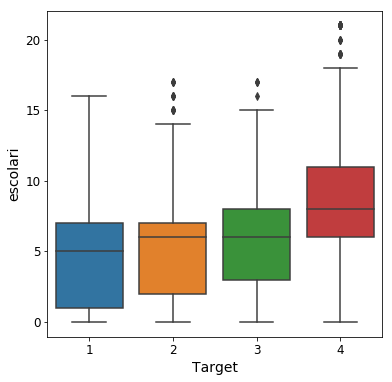

In [48]:
sns.boxplot(x='Target', y='escolari', data=train_data.loc[:train_data.shape[0]]);

Clearly it shows that education is lower in extreme poverty group compated to group4. May be poverty is affecting them to get educated

In [49]:
train_data_heads['v2a1'].describe()

count    8.170000e+02
mean     1.688092e+05
std      1.600460e+05
min      0.000000e+00
25%      7.500000e+04
50%      1.300000e+05
75%      2.000000e+05
max      2.353477e+06
Name: v2a1, dtype: float64

In [50]:
train_data_heads['v2a1'].count()

817

/opt/conda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


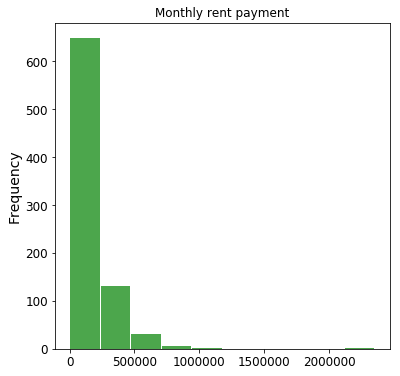

In [51]:
train_data_heads.v2a1.hist(figsize=(6,6), color='g', alpha=0.7, rwidth=0.97)
plt.title("Monthly rent payment")
plt.ylabel("Frequency")
plt.xticks()
plt.grid("off")
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


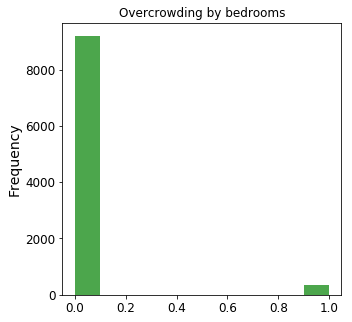

In [52]:
train_data.hacdor.hist(figsize=(5,5), color='g', alpha=0.7, rwidth=0.97)
plt.title("Overcrowding by bedrooms")
plt.ylabel("Frequency")
plt.grid("off")
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


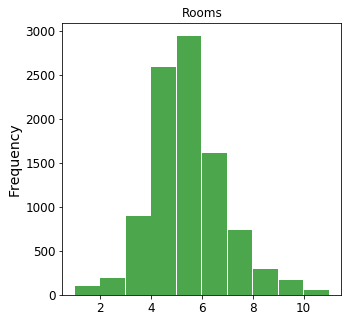

In [53]:
train_data.rooms.hist(figsize=(5,5), color='g', alpha=0.7, rwidth=0.97)
plt.title("Rooms")
plt.ylabel("Frequency")
plt.grid("off")
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


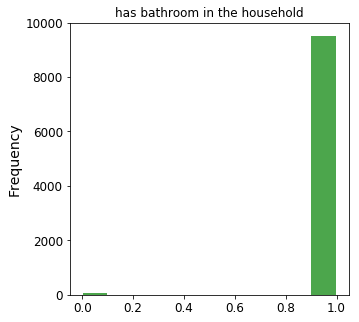

In [54]:
train_data.v14a.hist(figsize=(5,5), color='g', alpha=0.7, rwidth=0.97)
plt.title("has bathroom in the household")
plt.ylabel("Frequency")
plt.grid("off")
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


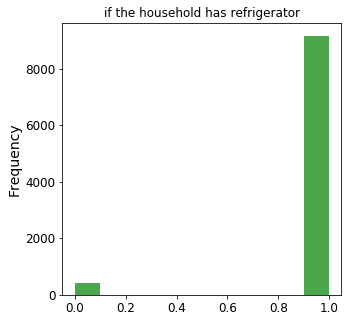

In [55]:
train_data.refrig.hist(figsize=(5,5), color='g', alpha=0.7, rwidth=0.97)
plt.title("if the household has refrigerator")
plt.ylabel("Frequency")
plt.grid("off")
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


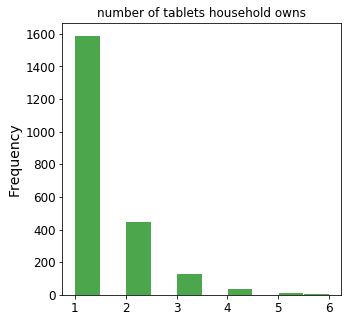

In [56]:
train_data.v18q1.hist(figsize=(5,5), color='g', alpha=0.7, rwidth=0.97)
plt.title("number of tablets household owns")
plt.ylabel("Frequency")
plt.grid("off")
plt.show()

### Conclusion:-

These features do not convey any useful information about the `Target` variable:
* 'sanitario1', 'sanitario6'
* 'elimbasu4', 'elimbasu5', 'elimbasu6'
* 'techozinc', 'techoentrepiso', 'techocane', 'techootro'
* 'abastaguadentro', 'abastaguafuera', 'abastaguano'
* 'public', 'planpri', 'noelec', 'coopele'

In [57]:
train_data.drop(columns=['sanitario1', 'sanitario6',
                       'elimbasu4', 'elimbasu5', 'elimbasu6',
                       'techozinc', 'techoentrepiso', 'techocane', 'techootro',
                       'abastaguadentro', 'abastaguafuera', 'abastaguano',
                       'public', 'planpri', 'noelec', 'coopele'], inplace=True)

## Test Dataset

Lets glance at the test data

In [58]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


Test data contains 23856 data rows with 142 columns. Difference between train and test columns is the 'Target' column which is the target variable.

Test data have 8 float columns, 129 integer columns and 5 object columns.

In [59]:
test_data.shape

(23856, 142)

In [60]:
pd.options.display.max_columns = 150
test_data.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,no,16,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324


In [61]:
missing_test= test_data.isnull().sum()
missing_test[missing_test!=0]

v2a1         17403
v18q1        18126
rez_esc      19653
meaneduc        31
SQBmeaned       31
dtype: int64

In [62]:
test_data.drop(columns=['sanitario1', 'sanitario6',
                       'elimbasu4', 'elimbasu5', 'elimbasu6',
                       'techozinc', 'techoentrepiso', 'techocane', 'techootro',
                       'abastaguadentro', 'abastaguafuera', 'abastaguano',
                       'public', 'planpri', 'noelec', 'coopele'], inplace=True)

 ### Columns with Null values arranged descending. 


In [63]:
missing_test_data=pd.DataFrame(missing_test[missing_test!=0].rename('Missing data'))
missing_test_data['Total rows in dataset'] = len(test_data)
missing_test_data['Percentage of missing data'] = missing_test[missing_test!=0]/len(test_data)

In [64]:
missing_test_data

,Missing data,Total rows in dataset,Percentage of missing data
v2a1,17403,23856,0.729502
v18q1,18126,23856,0.759809
rez_esc,19653,23856,0.823818
meaneduc,31,23856,0.001299
SQBmeaned,31,23856,0.001299


Test data also having huge number of null values in v2a1, v18q1 and rez_esc columns

# Data Pre-processing

For data pre-processing, lets combine Train and Test datasets

In [65]:
test_data['Target'] = 10

In [66]:
full_data = train_data.append(test_data, ignore_index = True)

In [67]:
full_data.shape

(33413, 127)

## Handling Missing Data

Lets cleanup the missing data from v18q1, v2a1 and rez_esc columns as they constitute large number of missing data points

### v18q1

- v18q -->  owns a tablet
- v18q1 --> number of tablets household owns

- v18q1-- Train data have around 7342 missing values. We can try to compare this missing values with the v18q to see if any of these owns a tablet. If none then we can replace the value directly with 0.


In [68]:
heads = full_data.loc[full_data['parentesco1'] == 1].copy()

In [69]:
# Compare the individual owning a tablet with the household
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

This shows that every member have null v18q1 have 0 in v18q. So we can safely replace the nulls with 0

In [70]:
full_data['v18q1'] = full_data['v18q1'].fillna(0)

Let's verify the data if the missing values for v18q1 is handled correctly.

In [71]:
missing_afterfix= full_data['v18q1'].isnull().sum()
missing_afterfix

0

So there is no missing data for v18q1 feature.

### rez_esc

- rez_esc --> Years behind school can be filled with 0 

**Analyzing data for rez_esc feature**

In [72]:
full_data['rez_esc'].describe()

count    5832.000000
mean        0.434842
std         1.581884
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        99.000000
Name: rez_esc, dtype: float64

In [73]:
full_data.loc[full_data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

The individuals having max age of 17 when the rex_esc is having null value and age having non-null value.

In [74]:
full_data.loc[full_data['rez_esc'].notnull()]['age'].unique()

array([17,  8,  7, 11, 15, 14, 13, 10,  9, 12, 16])

Lets see the unique values in rez_esc feature

In [75]:
full_data['rez_esc'].unique()

array([nan,  1.,  0.,  3.,  2.,  4.,  5., 99.])

Individuals who are having age below 7 and above 19 with rez_esc=null are considered as not educated and can set the value as 0

In [76]:
full_data.loc[((full_data['age'] > 19) | (full_data['age'] < 7)) & (full_data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
full_data['rez_esc-missing'] = full_data['rez_esc'].isnull()

In [77]:
full_data['rez_esc-missing'].unique()

array([False,  True])

### v2a1

There could be known reason for missing monthly payment or missing values here. 

- 1. The person can have his own home.We will set the value to 0 for such cases. 
- 2. Other missing due to unknown reason, we will impute the median value within pipeline 



In the example of v2a1 you should first filter by tipoviv3. Most households that don't have information will be households that do not rent or are not paying loans (tipoviv2). If a household is tipoviv3 and does not have information then you need to make a choice about the treatment of the variable either assume 0, impute a value or not use the variable. Basically in those cases we don't know the value. https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403#360609

**Standardize the value for v2a1 in the data**

In [78]:
full_data[['v2a1', 'tipovivi3']][full_data['tipovivi3'] == 0][full_data['v2a1'].isnull()].shape

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(24263, 2)

We see the households that are not rented are provided with values V2a1=Nan and tipovivi3=0. The rest of the missing values, we assign them to 0

In [79]:
full_data.loc[:, 'v2a1'].fillna(0, inplace=True)

In [80]:
full_data['v2a1-missing'] = full_data['v2a1'].isnull()

In [81]:
full_data['v2a1'].unique()

array([ 190000.,  135000.,       0.,  180000.,  130000.,  100000.,
         90000.,  215000.,  150000.,  120000.,   80000.,  168000.,
         40000.,  155000.,  200000.,  350000.,  270000.,  300000.,
        250000.,  260000.,  564834.,  175000.,   25310.,  400000.,
        450000.,  399378.,  119813.,  125518.,  125000.,   60000.,
         35000.,  160000.,  170000.,  500000.,  230000.,  185000.,
        220000.,  570540.,  342324.,  127000.,   52000.,  240000.,
        278000.,   70000.,  110000.,  100297.,  210000.,  770229.,
        285270.,  145000.,   96000.,  542013.,   65000.,   85000.,
        104000.,  275000.,  140000.,  280000.,  105661.,   20000.,
         16000.,   55000.,   30000.,  283000.,  245000.,  191500.,
        510000.,   36350.,   89000.,  600000.,   75000.,   50000.,
         84529.,  550000.,  132000.,  470000.,   27000.,  176000.,
        205000.,  380000.,  855810.,  427905.,  290975.,  188000.,
        118097.,  360000.,  325000., 1000000.,  700000.,  2887

### meaneduc and SQBmeaned

- meaneduc and SQBmeaned are related. SQBmeaned is the square of meaneduc. Both values are missing for 31 observations and we can impute it with median

**Standardise the values for meaneduc feature**

In [82]:
full_data.loc[:, 'meaneduc'].fillna(full_data['meaneduc'].mean(), inplace=True)

**Standardise the values for SQBmeaned feature**

In [83]:
full_data.loc[:, 'SQBmeaned'].fillna(full_data['SQBmeaned'].mean(), inplace=True)

### Fill in object columns 

- Fill in string values of below columns with "yes" = 1 and "no" = 0

- dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
- edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0


In [84]:
map_values = {"yes": 1, "no": 0}

# Fill in the values with the correct mapping
full_data['dependency'] = full_data['dependency'].replace(map_values).astype(np.float64)
full_data['edjefa'] = full_data['edjefa'].replace(map_values).astype(np.float64)
full_data['edjefe'] = full_data['edjefe'].replace(map_values).astype(np.float64)

full_data[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,33413.000000,33413.000000,33413.000000
mean,1.172238,2.827822,5.170353
std,1.649249,4.606153,5.214174
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


### Label distribution household level

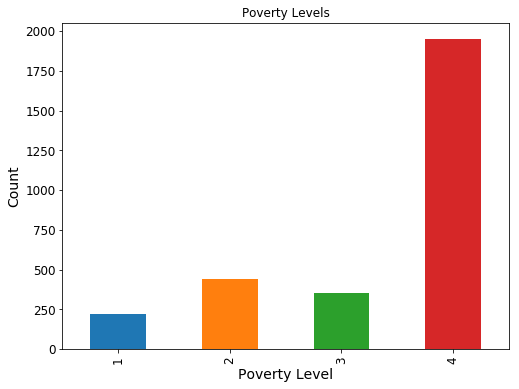

In [85]:
hh_head = full_data.loc[full_data['parentesco1'] == 1].copy()

full_data_labels = train_data.loc[(train_data['Target'].notnull()) & (full_data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
target_counts = full_data_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
target_counts.plot.bar(figsize = (8, 6), 
                      linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.title('Poverty Levels');


In [86]:
target_counts

1     222
2     442
3     355
4    1954
Name: Target, dtype: int64

#### Identify errors in household data

- Some of the labels are not correct because individuals in the same household have a different poverty level. We can use the head of household as the true label.

**Households where targets are not all equal**

In [87]:
# Groupby the household and figure out the number of unique values
equal = full_data.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

not_equal = equal[equal != True]
len(not_equal)

85

In [88]:
full_data[full_data['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


**Families without Heads of Household**

In [89]:
households_leader = full_data.groupby('idhogar')['parentesco1'].sum()

households_no_head = full_data.loc[full_data['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('{} households dont have a head.'.format(households_no_head['idhogar'].nunique()))

33 households dont have a head.


In [90]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    correct_target = int(full_data[(full_data['idhogar'] == household) & (full_data['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    full_data.loc[full_data['idhogar'] == household, 'Target'] = correct_target
    


In [91]:
#Verification
equal = full_data.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

not_equal = equal[equal != True]
len(not_equal)

0

## Verify Numerical and Categorical features after Data Pre-processing

**Verification of Training data**

Total number of Numerical features:  127
Total number of Categorical features:  2


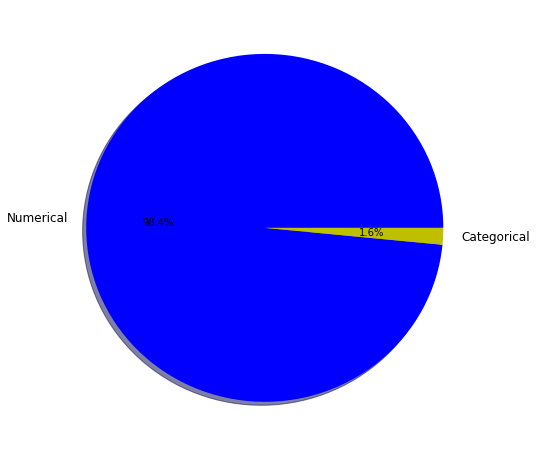

In [92]:
numerical_features = full_data._get_numeric_data().columns
numerical_features_length = len(numerical_features)

categorical_features = pd.Index(list(set(full_data.columns) - set(numerical_features)))
categorical_features_length = len(categorical_features)

print("Total number of Numerical features: ", numerical_features_length)
print("Total number of Categorical features: ", categorical_features_length)

labels = ['Numerical', 'Categorical']
colors = ['b', 'y']
plt.figure(figsize=(8, 8))
plt.pie([numerical_features_length, categorical_features_length], 
        labels=labels, 
        autopct='%1.1f%%', 
        shadow=True, 
        colors=colors);

In [93]:
full_data[categorical_features].head()

,idhogar,Id
0,21eb7fcc1,ID_279628684
1,0e5d7a658,ID_f29eb3ddd
2,2c7317ea8,ID_68de51c94
3,2b58d945f,ID_d671db89c
4,2b58d945f,ID_d56d6f5f5


All the data had been clean to have numerical values except idhogar and Id as they both are identifiers

## Convert dummy to ordinal

These features have order in their meaning:
```
etecho1, =1 if roof are bad
etecho2, =1 if roof are regular
etecho3, =1 if roof are good
epared1, =1 if walls are bad
epared2, =1 if walls are regular
epared3, =1 if walls are good
instlevel1, =1 no level of education
instlevel2, =1 incomplete primary
instlevel3, =1 complete primary
instlevel4, =1 incomplete academic secondary level
instlevel5, =1 complete academic secondary level
instlevel6, =1 incomplete technical secondary level
instlevel7, =1 complete technical secondary level
instlevel8, =1 undergraduate and higher education
instlevel9, =1 postgraduate higher education
eviv1, =1 if floor are bad
eviv2, =1 if floor are regular
eviv3, =1 if floor are good
```
We should use them as ordinal features.

In [94]:
full_data['WallQual'] = full_data['epared1'] + 2*full_data['epared2'] + 3*full_data['epared3']

full_data['RoofQual'] = full_data['etecho1'] + 2*full_data['etecho2'] + 3*full_data['etecho3']

full_data['FloorQual'] = full_data['eviv1'] + 2*full_data['eviv2'] + 3*full_data['eviv3']

full_data['EducationLevel'] = full_data['instlevel1'] + 2*full_data['instlevel2'] + 3*full_data['instlevel3'] + \
    4*full_data['instlevel4'] + 5*full_data['instlevel5'] + 6*full_data['instlevel6'] + 7*full_data['instlevel7'] + \
    8*full_data['instlevel8'] + 9*full_data['instlevel9']

In [95]:
full_data.drop(columns=['epared1', 'epared2', 'epared3',
                       'etecho1', 'etecho2', 'etecho3',
                       'eviv1', 'eviv2', 'eviv3',
                       'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5',
                       'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9'], inplace=True)

# Feature Engineering

We should consolidate our data at a household level. 
We already have some of the information for each household, but for training, we will need all of the information summarized for each household. This means grouping the individuals in a house (groupby) and performing an aggregation (agg) of the individual variables.



The process is as follows

    1.Break variables into household level and invididual level
    2.Find suitable aggregations for the individual level data
        - Ordinal variables can use statistical aggregations
        - Boolean variables can also be aggregated but with fewer stats
    3.Join the individual aggregations to the household level data


There are several different categories of variables:

    1.Individual Variables: these are characteristics of each individual rather than the household
        Boolean: Yes or No (0 or 1)
        Ordered Discrete: Integers with an ordering
    2.Household variables
        Boolean: Yes or No
        Ordered Discrete: Integers with an ordering
        Continuous numeric
    3.Squared Variables: derived from squaring variables in the data
    4.Id variables: identifies the data and should not be used as features


In [96]:
full_data.columns

Index(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q',
       'v18q1', 'r4h1',
       ...
       'SQBdependency', 'SQBmeaned', 'agesq', 'Target', 'rez_esc-missing',
       'v2a1-missing', 'WallQual', 'RoofQual', 'FloorQual', 'EducationLevel'],
      dtype='object', length=115)

In [97]:
id_fea = ['Id', 'idhogar', 'Target']

In [98]:
ind_bool_fea = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'EducationLevel', 'rez_esc-missing', 'v2a1-missing','mobilephone']

In [99]:
ind_ordered_fea = ['rez_esc', 'escolari', 'age']

In [100]:
hh_bool_fea = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera', 'WallQual', 'RoofQual', 'FloorQual', 
           'cielorazo', 'sanitario2', 'sanitario3', 'sanitario5',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2']

In [101]:
hh_ordered_fea = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

In [102]:
hh_cont_fea = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [103]:
sqr_fea = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']


In [104]:
x = ind_bool_fea + ind_ordered_fea + id_fea + hh_bool_fea + hh_ordered_fea + hh_cont_fea + sqr_fea

from collections import Counter

print('No Repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('Covered All: ', len(x) == full_data.shape[1])
print(len(x), full_data.shape[1])
full_data.columns

No Repeats:  True
Covered All:  True
115 115


Index(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q',
       'v18q1', 'r4h1',
       ...
       'SQBdependency', 'SQBmeaned', 'agesq', 'Target', 'rez_esc-missing',
       'v2a1-missing', 'WallQual', 'RoofQual', 'FloorQual', 'EducationLevel'],
      dtype='object', length=115)

## Remove Squared variables

- Squared variables can be removed from the list of features as original feature is aleady part of the dataset and both are highly correlated

In [105]:
full_data.shape

(33413, 115)

In [106]:
full_data = full_data.drop(columns = sqr_fea)

## Household level variables

In [107]:
hh_fea = full_data.loc[full_data['parentesco1'] == 1, :]
hh_fea = hh_fea[id_fea + hh_bool_fea + hh_cont_fea + hh_ordered_fea]
hh_fea.shape

(10307, 76)

### Remove unnecessary Household Variables

- We can remove highly correlated variables keeping just one out of them.

In [108]:
# Create correlation matrix
corr_matrix = hh_fea.corr()
corr_matrix

,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,WallQual,RoofQual,FloorQual,cielorazo,sanitario2,sanitario3,sanitario5,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,v18q1,tamhog,tamviv,hhsize,hogar_nin,hogar_adul,hogar_mayor,hogar_total,bedrooms,qmobilephone
Target,1.000000,0.012493,0.008439,-0.003072,0.017784,0.017408,-0.005246,0.002869,-0.005382,-0.015608,-0.023736,0.006125,-0.002678,-0.000983,0.019876,0.011544,-0.027957,-0.014060,-0.021490,0.019746,0.026833,0.018078,0.018354,0.012360,-0.009619,0.001095,-0.004209,0.003579,0.006531,-0.023128,-0.000002,0.002112,-0.002899,0.005030,0.019261,-0.015791,-0.007832,-0.004401,0.025601,0.016958,0.003786,-0.010882,0.006346,0.003963,0.001282,-0.007344,0.008687,-0.008687,0.012144,0.002136,0.024732,-0.004731,0.020012,-0.006576,0.024744,-0.002310,0.018405,0.014458,-0.025417,-0.001960,-0.015021,-0.017989,0.011891,-0.000422,0.011170,0.000854,0.004429,0.000854,-0.019869,0.023827,0.007324,0.000854,0.021327,0.023333
hacdor,0.012493,1.000000,0.593867,-0.086701,-0.066409,-0.113787,0.026165,0.019816,0.110713,0.122610,0.068846,0.086632,-0.007015,-0.005960,-0.143259,-0.005960,0.026892,0.116650,0.026372,-0.158938,-0.136416,-0.174070,-0.148678,0.006987,-0.030309,0.053491,-0.012058,-0.035395,0.023407,0.033674,-0.060450,0.029765,0.051689,-0.083256,-0.043135,0.046399,0.121261,0.072329,-0.054428,-0.041849,-0.054110,0.009782,0.027159,-0.008010,0.037814,0.030319,-0.009123,0.009123,-0.032769,0.019191,-0.047917,-0.027628,-0.092843,0.620093,-0.197812,0.243406,0.050627,0.175272,0.219364,0.095605,0.191594,0.302703,0.099775,0.246122,-0.054685,0.246793,0.297433,0.246793,0.295757,0.043431,-0.058321,0.246793,-0.189177,0.026514
hacapo,0.008439,0.593867,1.000000,-0.123276,-0.075336,-0.094350,0.022254,0.007634,0.089127,0.134901,0.042265,0.118369,-0.005219,-0.004434,-0.120922,-0.004434,-0.002458,0.115475,0.023931,-0.129476,-0.117711,-0.157484,-0.131246,-0.013006,-0.027034,0.089556,0.002071,-0.028908,0.011194,0.042592,-0.056761,0.030683,0.045590,-0.061334,-0.038374,0.030007,0.122973,0.050853,-0.039341,-0.035871,-0.055738,0.009390,0.029604,-0.005307,0.026064,0.041579,-0.012488,0.012488,-0.029459,0.011497,-0.039651,-0.026451,-0.088364,0.467570,-0.200073,0.188811,0.056090,0.150316,0.170801,0.063220,0.140345,0.235222,0.082186,0.194963,-0.047469,0.195462,0.252206,0.195462,0.223288,0.046811,-0.043296,0.195462,-0.126525,0.036755
v14a,-0.003072,-0.086701,-0.123276,1.000000,0.145417,0.065795,0.002527,0.007668,-0.020410,-0.128082,-0.068496,-0.034484,0.003483,0.002960,0.094633,0.002960,-0.057915,-0.140181,-0.076321,0.084392,0.073872,0.093363,0.087430,0.022767,0.082497,-0.135782,-0.125215,0.037976,0.000772,-0.050813,0.068897,-0.044379,-0.053410,0.023597,0.019485,0.012576,-0.055029,-0.053133,0.020239,0.039564,0.043420,-0.020296,-0.022322,0.013448,-0.032355,-0.015887,0.017786,-0.017786,0.019346,-0.010997,0.031239,0.002257,0.046909,-0.084818,0.117383,-0.041715,0.020611,-0.005037,-0.008685,0.026958,0.016617,-0.033149,0.032675,0.007800,0.025383,0.007458,0.012717,0.007458,-0.027787,0.042932,0.017662,0.007458,0.080487,0.046128
refrig,0.017784,-0.066409,-0.075336,0.145417,1.000000,0.128958,-0.042125,-0.006812,-0.099088,-0.088633,-0.114895,-0.049882,-0.013233,0.007742,0.184785,0.007742,-0.019392,-0.162552,-0.105376,0.145450,0.110045,0.148836,0.169536,0.031297,0.037906,-0.159109,-0.186525,0.062921,0.026823,-0.153555,0.158660,-0.102393,-0.119884,0.055164,0.051212,-0.031018,-0.054314,-0.082873,0.060900,0.099595,0.095877,-0.015985,-0.035290,-0.006430,-0.067792,-0.044727,0.081086,-0.081086,0.042326,-0.039286,0.060726,0.042954,0.139550,-0.062800,0.1676

In [109]:
# Select upper triangle of correlation matrix
high_cor = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
col_to_drop = [column for column in high_cor.columns if any(abs(high_cor[column]) > 0.95)]

col_to_drop

['area2', 'tamhog', 'hhsize', 'hogar_total']

In [110]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


tamviv might not be the same as hhsize because there might be family members that are not living in the household.

In [111]:
hh_fea = hh_fea.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

### Remove area2

This means the house is in a rural zone, but it's redundant because we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.

In [112]:
hh_fea = hh_fea.drop(columns = 'area2')

### Create new variable 'poor_family'

- Combine No toilet, no electricity, no floor, no water service, no ceiling


In [113]:
# No floor, no ceiling
hh_fea['poor_family'] =  (hh_fea['pisonotiene'] + (hh_fea['cielorazo'] == 0))

In [114]:
hh_fea['poor_family'].tail()

33393    1
33398    1
33400    1
33404    1
33409    1
Name: poor_family, dtype: int64

In [115]:
hh_fea.shape

(10307, 73)

### Create new variable 'rich_family'

- Create a new variable combining variables for a refrigerator, computer, tablet, or television.

In [116]:
# Owns a refrigerator, computer, tablet, and television
hh_fea['bonus'] =  (hh_fea['refrig'] + 
                      hh_fea['computer'] + 
                      (hh_fea['v18q1'] > 0) + 
                      hh_fea['television'])


## Create per capita variables

In [117]:
hh_fea['phones-per-capita'] = hh_fea['qmobilephone'] / hh_fea['tamviv']
hh_fea['tablets-per-capita'] = hh_fea['v18q1'] / hh_fea['tamviv']
hh_fea['rooms-per-capita'] = hh_fea['rooms'] / hh_fea['tamviv']
hh_fea['rent-per-capita'] = hh_fea['v2a1'] / hh_fea['tamviv']


## Individual level variables

In [118]:
ind_fea = full_data[id_fea + ind_bool_fea + ind_ordered_fea]
ind_fea.shape

(33413, 33)

In [119]:
# Create correlation matrix
corr_matrix = ind_fea.corr()

# Select upper triangle of correlation matrix
high_cor = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
ind_col_to_drop = [column for column in high_cor.columns if any(abs(high_cor[column]) > 0.95)]

ind_col_to_drop

['female', 'escolari']

This is opposite of male and can be removed

In [120]:
ind_fea = ind_fea.drop(columns = 'male')

### New variable - escolari/age

In [121]:
ind_fea['escolari/age'] = ind_fea['escolari'] / ind_fea['age']
new_ind = ind_fea

## Aggregate data for household

In order to incorporate the individual data into the household data, we need to aggregate it for each household. The simplest way to do this is to groupby the family id idhogar and then agg the data. For the aggregations for ordered or continuous variables, we can use six, five of which are built in to pandas, and one of which we define ourselves range_. 

In [122]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = new_ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                                 \
           min max sum count  std range_ min max sum count       std range_   
idhogar                                                                       
000a08204    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   

          female                                estadocivil1                \
             min max sum count       std range_          min max sum count   
idhogar                                                                      
000a08204      0   1   1     3  0.577350      1            0   1   1     3   
000bce7c4      0   1   1     2  0.707107      1            0   0   0     2   
001845fb0      0   1   2     4  0.577350      1            0   0   0     4   
001ff74ca      1   1   2     2  0.000000      0            0   1   1     2   
003123ec2      0   1   1     4  0.500000      1            0   1   2     4   

                           estadocivil2                                \
                std range_          min max sum count      std range_   
idhogar                                                                 
000a08204  0.577350      1            0   1   2     3  0.57735      1   
000bce7c4  0.000000      0            0   0   0     2  0.00000      0   
001845fb0  0.000000      0            0   1   2     4  0.57735      1   
001ff74ca  0.707107      1            0   0   0     2  0.00000      0   
003123ec2  0.577350      1            0   1   2     4  0.57735      1   

          estadocivil3                           estadocivil4                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            1   1   2     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   0   0     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                      estadocivil5                                 \
           std range_          min max sum count       std range_   
idhogar                                                             
000a08204  0.0      0            0   0   0     3  0.000000      0   
000bce7c4  0.0      0            0   0   0     2  0.000000      0   
001845fb0  0.0      0            0   0   0     4  0.000000      0   
001ff74ca  0.0      0            0   1   1     2  0.707107      1   
003123ec2  0.0      0            0   0   0     4  0.000000      0   

          estadocivil6                           estadocivil7                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            0   0   0     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   1   2     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                          parentesco1                                 \
               std range_         min max sum count       std range_   
idhogar                                                                
000a08204  0.00000      0           0   1   1     3  0.577350      1   
000bce7c4  0.00000      0           0   1   1     2  0.70710

In [123]:
# Rename the columns
ind_new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        ind_new_col.append(c+stat)
        


In [130]:
ind_new_col


['v18qmin',
 'v18qmax',
 'v18qsum',
 'v18qcount',
 'v18qstd',
 'v18qrange_',
 'dismin',
 'dismax',
 'dissum',
 'discount',
 'disstd',
 'disrange_',
 'femalemin',
 'femalemax',
 'femalesum',
 'femalecount',
 'femalestd',
 'femalerange_',
 'estadocivil1min',
 'estadocivil1max',
 'estadocivil1sum',
 'estadocivil1count',
 'estadocivil1std',
 'estadocivil1range_',
 'estadocivil2min',
 'estadocivil2max',
 'estadocivil2sum',
 'estadocivil2count',
 'estadocivil2std',
 'estadocivil2range_',
 'estadocivil3min',
 'estadocivil3max',
 'estadocivil3sum',
 'estadocivil3count',
 'estadocivil3std',
 'estadocivil3range_',
 'estadocivil4min',
 'estadocivil4max',
 'estadocivil4sum',
 'estadocivil4count',
 'estadocivil4std',
 'estadocivil4range_',
 'estadocivil5min',
 'estadocivil5max',
 'estadocivil5sum',
 'estadocivil5count',
 'estadocivil5std',
 'estadocivil5range_',
 'estadocivil6min',
 'estadocivil6max',
 'estadocivil6sum',
 'estadocivil6count',
 'estadocivil6std',
 'estadocivil6range_',
 'estadocivil

In [131]:
ind_agg.columns = ind_new_col
ind_agg.head()

,v18qmin,v18qmax,v18qsum,v18qcount,v18qstd,v18qrange_,dismin,dismax,dissum,discount,disstd,disrange_,femalemin,femalemax,femalesum,femalecount,femalestd,femalerange_,estadocivil1min,estadocivil1max,estadocivil1sum,estadocivil1count,estadocivil1std,estadocivil1range_,estadocivil2min,estadocivil2max,estadocivil2sum,estadocivil2count,estadocivil2std,estadocivil2range_,estadocivil3min,estadocivil3max,estadocivil3sum,estadocivil3count,estadocivil3std,estadocivil3range_,estadocivil4min,estadocivil4max,estadocivil4sum,estadocivil4count,estadocivil4std,estadocivil4range_,estadocivil5min,estadocivil5max,estadocivil5sum,estadocivil5count,estadocivil5std,estadocivil5range_,estadocivil6min,estadocivil6max,estadocivil6sum,estadocivil6count,estadocivil6std,estadocivil6range_,estadocivil7min,estadocivil7max,estadocivil7sum,estadocivil7count,estadocivil7std,estadocivil7range_,parentesco1min,parentesco1max,parentesco1sum,parentesco1count,parentesco1std,parentesco1range_,parentesco2min,parentesco2max,parentesco2sum,parentesco2count,parentesco2std,parentesco2range_,parentesco3min,parentesco3max,parentesco3sum,...,parentesco6count,parentesco6std,parentesco6range_,parentesco7min,parentesco7max,parentesco7sum,parentesco7count,parentesco7std,parentesco7range_,parentesco8min,parentesco8max,parentesco8sum,parentesco8count,parentesco8std,parentesco8range_,parentesco9min,parentesco9max,parentesco9sum,parentesco9count,parentesco9std,parentesco9range_,parentesco10min,parentesco10max,parentesco10sum,parentesco10count,parentesco10std,parentesco10range_,parentesco11min,parentesco11max,parentesco11sum,parentesco11count,parentesco11std,parentesco11range_,parentesco12min,parentesco12max,parentesco12sum,parentesco12count,parentesco12std,parentesco12range_,EducationLevelmin,EducationLevelmax,EducationLevelsum,EducationLevelcount,EducationLevelstd,EducationLevelrange_,mobilephonemin,mobilephonemax,mobilephonesum,mobilephonecount,mobilephonestd,mobilephonerange_,rez_escmin,rez_escmax,rez_escsum,rez_esccount,rez_escstd,rez_escrange_,escolarimin,escolarimax,escolarisum,escolaricount,escolaristd,escolarirange_,agemin,agemax,agesum,agecount,agestd,agerange_,escolari/agemin,escolari/agemax,escolari/agesum,escolari/agecount,escolari/agestd,escolari/agerange_
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.000000,0,0,0,0,3,0.0,0,0,0,0,3,0.00000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,1,...,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,1,8,17,3,4.041452,7,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0.000000,0.500000,0.900000,3,0.264575,0.500000
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,2,0.000000,0,0,0,0,2,0.00000,0,1,1,2,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,0,0,0,2,0.00000,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,...,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,1,2,3,2,0.707107,1,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,0,5,5,2,3.535534,5,60,63,123,2,2.121320,3,0.000000,0.083333,0.083333,2,0.058926,0.083333
001845fb0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,2,4,0.577350,1,0,0,0,4,0.000000,0,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,0,0,4,0.0,0,0,1,2,4,0.57735,1,0,1,1,4,0.500000,1,0,1,1,4,0.500000,1,0,1,2,...,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,3,8,20,4,2.160247,5,1,1,4,4,0.0,0,0.0,0.0,0.0,3,0.0,0.0,6,14,41,4,3.304038,8,19,52,142,4,16.421531,33,0.115385,0.526316,1.397906,4,0.183106,0.410931
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,0.000000,0,1,1,2,2,0.000000,0,0,1,1,2,0.707107,1,0,0,0,2,0.00000,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,0,0,2,0.0,0,0,0,0,2,0.00000,0,0,1,1,2,0.7071

In [132]:
ind_feats = list(ind_agg.columns)

In [133]:
final = hh_fea.merge(ind_agg, on = 'idhogar', how = 'left')

In [134]:
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,WallQual,RoofQual,FloorQual,cielorazo,sanitario2,sanitario3,sanitario5,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,v18q1,tamviv,hhsize,hogar_nin,hogar_adul,hogar_mayor,bedrooms,qmobilephone,poor_family,bonus,phones-per-capita,...,parentesco6count,parentesco6std,parentesco6range_,parentesco7min,parentesco7max,parentesco7sum,parentesco7count,parentesco7std,parentesco7range_,parentesco8min,parentesco8max,parentesco8sum,parentesco8count,parentesco8std,parentesco8range_,parentesco9min,parentesco9max,parentesco9sum,parentesco9count,parentesco9std,parentesco9range_,parentesco10min,parentesco10max,parentesco10sum,parentesco10count,parentesco10std,parentesco10range_,parentesco11min,parentesco11max,parentesco11sum,parentesco11count,parentesco11std,parentesco11range_,parentesco12min,parentesco12max,parentesco12sum,parentesco12count,parentesco12std,parentesco12range_,EducationLevelmin,EducationLevelmax,EducationLevelsum,EducationLevelcount,EducationLevelstd,EducationLevelrange_,mobilephonemin,mobilephonemax,mobilephonesum,mobilephonecount,mobilephonestd,mobilephonerange_,rez_escmin,rez_escmax,rez_escsum,rez_esccount,rez_escstd,rez_escrange_,escolarimin,escolarimax,escolarisum,escolaricount,escolaristd,escolarirange_,agemin,agemax,agesum,agecount,agestd,agerange_,escolari/agemin,escolari/agemax,escolari/agesum,escolari/agecount,escolari/agestd,escolari/agerange_
0,ID_279628684,21eb7fcc1,4,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,190000.0,0.0,10.0,0.0,10.0,1.000000,3,0,1,1,0,0,0,0,1,0.0,1,1,0,1,0,1,1,0,1,1.00,...,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,4,4,4,1,NaN,0,1,1,1,1,NaN,0,0.0,0.0,0.0,1,NaN,0.0,10,10,10,1,NaN,0,43,43,43,1,NaN,0,0.232558,0.232558,0.232558,1,NaN,0.000000
1,ID_f29eb3ddd,0e5d7a658,4,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,2,2,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,135000.0,8.0,12.0,0.0,12.0,1.000000,4,0,1,1,0,0,0,0,1,1.0,1,1,0,1,1,1,1,0,2,1.00,...,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,8,8,8,1,NaN,0,1,1,1,1,NaN,0,0.0,0.0,0.0,1,NaN,0.0,12,12,12,1,NaN,0,67,67,67,1,NaN,0,0.179104,0.179104,0.179104,1,NaN,0.000000
2,ID_68de51c94,2c7317ea8,4,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,3,3,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0.0,8.0,0.0,11.0,11.0,0.500000,8,0,0,0,0,1,1,0,1,0.0,1,1,0,1,1,2,0,0,1,0.00,...,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,5,5,5,1,NaN,0,0,0,0,1,NaN,0,0.0,0.0,0.0,1,NaN,0.0,11,11,11,1,NaN,0,92,92,92,1,NaN,0,0.119565,0.119565,0.119565,1,NaN,0.000000
3,ID_ec05b1a7b,2b58d945f,4,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3,3,3,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,180000.0,1.0,11.0,0.0,11.0,1.333333,5,0,2,2,1,1,2,1,3,1.0,4,4,2,2,0,3,3,0,2,0.75,...,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,2,5,16,4,1.414214,3,1,1,4,4,0.0,0,0.0,1.0,1.0,4,0.5,1.0,2,11,33,4,4.272002,9,8,38,100,4,14.899664,30,0.250000,0.529412,1.366183,4,0.126943,0.279412
4,ID_1284f8aad,d6dae86b7,4,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,2,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,130000.0,1.0,9.0,0.0,10.0,4.000000,2,0,1,1,2,1,3,2,2,0.0,4,4,2,2,0,1,1,0,1,0.25,...,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,1,5,12,4,1.825742,4,1,1,4,4,0.0,0,0.0,1.0,1.0,4,0.5,1.0,0,11,23,4,5.123475,11,7,30,76,4,11.690452,23,0.000000,0.392857,0.965584,4,0.168946,0.392857


In [135]:
final.shape

(10307, 246)

In [136]:
final1=final

# Train and validation data split and data preparation

In [137]:
final1['Target'] = final1['Target'].replace(10, np.nan)

In [138]:
final1["Target"].unique()

array([ 4.,  2.,  3.,  1., nan])

In [139]:
# Extract the training data
train_set = final1[final1['Target'].notnull()].drop(columns = ['Id', 'idhogar'])
test_set = final1[final1['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

In [140]:
train_set.shape

(2973, 244)

In [141]:
test_set.shape

(7334, 243)

In [142]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_set, train_set["Target"]):
    strat_train_set = train_set.loc[train_index]
    strat_test_set = train_set.loc[test_index]

In [143]:
train_set["Target"].value_counts() / len(train_set)

4.0    0.657249
2.0    0.148671
3.0    0.119408
1.0    0.074672
Name: Target, dtype: float64

In [144]:
strat_train_set.shape

(2378, 244)

In [145]:
strat_test_set.shape

(595, 244)

In [146]:
X_train = strat_train_set.drop("Target", axis=1) # drop labels for training set
y_train = strat_train_set["Target"].copy()

In [147]:
X_train.shape

(2378, 243)

In [148]:
y_train.shape

(2378,)

In [149]:
X_test = strat_test_set.drop("Target", axis=1) # drop labels for training set
y_test = strat_test_set["Target"].copy()

In [150]:
X_test.shape

(595, 243)

In [151]:
y_test.shape

(595,)

In [152]:
X_train.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,WallQual,RoofQual,FloorQual,cielorazo,sanitario2,sanitario3,sanitario5,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,v18q1,tamviv,hhsize,hogar_nin,hogar_adul,hogar_mayor,bedrooms,qmobilephone,poor_family,bonus,phones-per-capita,tablets-per-capita,rooms-per-capita,rent-per-capita,...,parentesco6count,parentesco6std,parentesco6range_,parentesco7min,parentesco7max,parentesco7sum,parentesco7count,parentesco7std,parentesco7range_,parentesco8min,parentesco8max,parentesco8sum,parentesco8count,parentesco8std,parentesco8range_,parentesco9min,parentesco9max,parentesco9sum,parentesco9count,parentesco9std,parentesco9range_,parentesco10min,parentesco10max,parentesco10sum,parentesco10count,parentesco10std,parentesco10range_,parentesco11min,parentesco11max,parentesco11sum,parentesco11count,parentesco11std,parentesco11range_,parentesco12min,parentesco12max,parentesco12sum,parentesco12count,parentesco12std,parentesco12range_,EducationLevelmin,EducationLevelmax,EducationLevelsum,EducationLevelcount,EducationLevelstd,EducationLevelrange_,mobilephonemin,mobilephonemax,mobilephonesum,mobilephonecount,mobilephonestd,mobilephonerange_,rez_escmin,rez_escmax,rez_escsum,rez_esccount,rez_escstd,rez_escrange_,escolarimin,escolarimax,escolarisum,escolaricount,escolaristd,escolarirange_,agemin,agemax,agesum,agecount,agestd,agerange_,escolari/agemin,escolari/agemax,escolari/agesum,escolari/agecount,escolari/agestd,escolari/agerange_
2174,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,2,2,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,90000.0,1.0,0.0,10.0,8.000000,2.000000,4,1,2,3,0,1,1,1,3,1.0,4,4,2,2,0,2,3,1,3,0.750000,0.25,1.000000,22500.0,...,4,0.0,0,0,0,0,4,0.00000,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,1,4,10,4,1.290994,3,1,1,4,4,0.0,0,0.0,0.0,0.0,4,0.0,0.0,0,10,21,4,4.112988,10,7,38,89,4,15.063753,31,0.000000,0.416667,0.887061,4,0.182098,0.416667
1773,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,50000.0,0.0,9.0,0.0,7.500000,0.666667,7,0,1,1,0,1,1,0,2,0.0,2,2,0,2,0,3,2,1,2,1.000000,0.00,3.500000,25000.0,...,2,0.0,0,0,0,0,2,0.00000,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,3,4,7,2,0.707107,1,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,6,9,15,2,2.121320,3,37,38,75,2,0.707107,1,0.157895,0.243243,0.401138,2,0.060351,0.085349
1958,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,1.0,0.0,9.0,9.000000,1.000000,3,1,0,1,0,1,1,1,1,0.0,2,2,1,1,0,2,1,1,1,0.500000,0.00,1.500000,0.0,...,2,0.0,0,0,0,0,2,0.00000,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,2,4,6,2,1.414214,2,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,1,9,10,2,5.656854,8,7,40,47,2,23.334524,33,0.142857,0.225000,0.367857,2,0.058084,0.082143
2227,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3,3,3,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0.0,2.0,0.0,0.0,3.333333,1.000000,5,0,1,1,0,2,2,0,3,0.0,3,3,0,3,2,3,2,0,1,0.666667,0.00,1.666667,0.0,...,3,0.0,0,0,1,1,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,1,4,6,3,1.732051,3,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,10,10,3,5.773503,10,32,93,191,3,30.566867,61,0.000000,0.312500,0.312500,3,0.180422,0.312500
1901,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3,2,3,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,140000.0,1.0,11.0,0.0,11.000000,2.000000,4,0,2,2,1,1,2,1,3,1.0,4,4,2,2,0,2,2,0,2,0.500000,0.25,1.000000,35000.0,...,4,0.0,0,0,0,0,4,0.00000,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,1,5,13,4,2.061553,4,1,1,4,4,0.0,0,0.

In [153]:
X_train1 = X_train

# Data preparation pipeline

In [154]:
X_train.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,WallQual,RoofQual,FloorQual,cielorazo,sanitario2,sanitario3,sanitario5,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,v18q1,tamviv,hhsize,hogar_nin,hogar_adul,hogar_mayor,bedrooms,qmobilephone,poor_family,bonus,phones-per-capita,tablets-per-capita,rooms-per-capita,rent-per-capita,...,parentesco6count,parentesco6std,parentesco6range_,parentesco7min,parentesco7max,parentesco7sum,parentesco7count,parentesco7std,parentesco7range_,parentesco8min,parentesco8max,parentesco8sum,parentesco8count,parentesco8std,parentesco8range_,parentesco9min,parentesco9max,parentesco9sum,parentesco9count,parentesco9std,parentesco9range_,parentesco10min,parentesco10max,parentesco10sum,parentesco10count,parentesco10std,parentesco10range_,parentesco11min,parentesco11max,parentesco11sum,parentesco11count,parentesco11std,parentesco11range_,parentesco12min,parentesco12max,parentesco12sum,parentesco12count,parentesco12std,parentesco12range_,EducationLevelmin,EducationLevelmax,EducationLevelsum,EducationLevelcount,EducationLevelstd,EducationLevelrange_,mobilephonemin,mobilephonemax,mobilephonesum,mobilephonecount,mobilephonestd,mobilephonerange_,rez_escmin,rez_escmax,rez_escsum,rez_esccount,rez_escstd,rez_escrange_,escolarimin,escolarimax,escolarisum,escolaricount,escolaristd,escolarirange_,agemin,agemax,agesum,agecount,agestd,agerange_,escolari/agemin,escolari/agemax,escolari/agesum,escolari/agecount,escolari/agestd,escolari/agerange_
2174,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,2,2,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,90000.0,1.0,0.0,10.0,8.000000,2.000000,4,1,2,3,0,1,1,1,3,1.0,4,4,2,2,0,2,3,1,3,0.750000,0.25,1.000000,22500.0,...,4,0.0,0,0,0,0,4,0.00000,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,1,4,10,4,1.290994,3,1,1,4,4,0.0,0,0.0,0.0,0.0,4,0.0,0.0,0,10,21,4,4.112988,10,7,38,89,4,15.063753,31,0.000000,0.416667,0.887061,4,0.182098,0.416667
1773,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,50000.0,0.0,9.0,0.0,7.500000,0.666667,7,0,1,1,0,1,1,0,2,0.0,2,2,0,2,0,3,2,1,2,1.000000,0.00,3.500000,25000.0,...,2,0.0,0,0,0,0,2,0.00000,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,3,4,7,2,0.707107,1,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,6,9,15,2,2.121320,3,37,38,75,2,0.707107,1,0.157895,0.243243,0.401138,2,0.060351,0.085349
1958,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,1.0,0.0,9.0,9.000000,1.000000,3,1,0,1,0,1,1,1,1,0.0,2,2,1,1,0,2,1,1,1,0.500000,0.00,1.500000,0.0,...,2,0.0,0,0,0,0,2,0.00000,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,2,4,6,2,1.414214,2,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,1,9,10,2,5.656854,8,7,40,47,2,23.334524,33,0.142857,0.225000,0.367857,2,0.058084,0.082143
2227,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3,3,3,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0.0,2.0,0.0,0.0,3.333333,1.000000,5,0,1,1,0,2,2,0,3,0.0,3,3,0,3,2,3,2,0,1,0.666667,0.00,1.666667,0.0,...,3,0.0,0,0,1,1,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,1,4,6,3,1.732051,3,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,10,10,3,5.773503,10,32,93,191,3,30.566867,61,0.000000,0.312500,0.312500,3,0.180422,0.312500
1901,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3,2,3,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,140000.0,1.0,11.0,0.0,11.000000,2.000000,4,0,2,2,1,1,2,1,3,1.0,4,4,2,2,0,2,2,0,2,0.500000,0.25,1.000000,35000.0,...,4,0.0,0,0,0,0,4,0.00000,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,1,5,13,4,2.061553,4,1,1,4,4,0.0,0,0.

In [155]:
columns = X_train.columns
print(len(columns))

243


In [156]:
for p in columns:
    print(p)

hacdor
hacapo
v14a
refrig
paredblolad
paredzocalo
paredpreb
pisocemento
pareddes
paredmad
paredzinc
paredfibras
paredother
pisomoscer
pisoother
pisonatur
pisonotiene
pisomadera
WallQual
RoofQual
FloorQual
cielorazo
sanitario2
sanitario3
sanitario5
energcocinar1
energcocinar2
energcocinar3
energcocinar4
elimbasu1
elimbasu2
elimbasu3
tipovivi1
tipovivi2
tipovivi3
tipovivi4
tipovivi5
computer
television
lugar1
lugar2
lugar3
lugar4
lugar5
lugar6
area1
v2a1
dependency
edjefe
edjefa
meaneduc
overcrowding
rooms
r4h1
r4h2
r4h3
r4m1
r4m2
r4m3
r4t1
r4t2
v18q1
tamviv
hhsize
hogar_nin
hogar_adul
hogar_mayor
bedrooms
qmobilephone
poor_family
bonus
phones-per-capita
tablets-per-capita
rooms-per-capita
rent-per-capita
v18qmin
v18qmax
v18qsum
v18qcount
v18qstd
v18qrange_
dismin
dismax
dissum
discount
disstd
disrange_
femalemin
femalemax
femalesum
femalecount
femalestd
femalerange_
estadocivil1min
estadocivil1max
estadocivil1sum
estadocivil1count
estadocivil1std
estadocivil1range_
estadocivil2min
estad

** I have completed the task until here for today. Dhanya, you can select from the above features and update in below  num_attribs, and cat_attribs accordingly.**

** For now we do have these below data already set. You need to work on this dataset**

**Data for training and test split from the train_set**
- X_train
- y_train
- X_test
- y_test

**Data for final test set**
- test_set

** We can have discussion at same time of our meetup. 6pmPST today**

In [157]:
X_train.shape

(2378, 243)

In [158]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [159]:
from sklearn.pipeline import Pipeline, FeatureUnion

# Identify the numeric features we wish to consider. 
num_attribs = ["v2a1",
"dependency",
"meaneduc",
"overcrowding",
"poor_family",
"phones-per-capita",
"tablets-per-capita",
"rooms-per-capita",
"rent-per-capita",
"v18qmin",
"v18qsum",
"v18qcount",
"v18qstd",
"v18qrange_",
"dismin",
"dismax",
"dissum",
"femalemin",
"femalemax",
"femalesum",
"femalestd",
"femalerange_",
"estadocivil1min",
"estadocivil1max",
"estadocivil1sum",
"estadocivil2min",
"estadocivil2max",
"estadocivil2std",
"estadocivil3min",
"estadocivil3max",
"estadocivil3std",
"estadocivil4min",
"estadocivil4max",
"estadocivil5min",
"estadocivil5max",
"estadocivil5sum",
"estadocivil6min",
"estadocivil6max",
"estadocivil7min",
"estadocivil7max",
"estadocivil7sum",
"estadocivil7std",
"parentesco1min",
"parentesco1max",
"parentesco1std",
"parentesco2min",
"parentesco2max",
"parentesco3min",
"parentesco3max",
"parentesco3sum",
"parentesco4min",
"parentesco4max",
"parentesco4sum",
"parentesco5min",
"parentesco5max",
"parentesco6min",
"parentesco6max",
"parentesco6sum",
"parentesco7min",
"parentesco7max",
"parentesco8min",
"parentesco8max",
"parentesco9min",
"parentesco9max",
"parentesco9sum",
"parentesco10min",
"parentesco10max",
"parentesco10sum",
"parentesco11min",
"parentesco11max",
"parentesco11sum",
"parentesco12min",
"parentesco12max",
"parentesco12sum",
"mobilephonemin",
"mobilephonestd",
"mobilephonerange_",
"rez_escmin",
"rez_escmax",
"escolarimin",
"escolarimax",
"escolarisum",
"escolaristd",
"escolarirange_",
"agemin",
"agemax",
"agesum",
"agestd",
"agerange_",
"escolari/agemin",
"escolari/agemax",
"escolari/agesum",
"escolari/agestd",
"escolari/agerange_",
"bonus",
"v18qmax",
"discount",
"disstd",
"disrange_",
"femalecount",
"estadocivil1count",
"estadocivil1std",
"estadocivil1range_",
"estadocivil2sum",
"estadocivil2count",
"estadocivil2range_",
"estadocivil3sum",
"estadocivil3count",
"estadocivil3range_",
"estadocivil4sum",
"estadocivil4count",
"estadocivil4std",
"estadocivil4range_",
"estadocivil5count",
"estadocivil5std",
"estadocivil5range_",
"estadocivil6sum",
"estadocivil6count",
"estadocivil6std",
"estadocivil6range_",
"estadocivil7count",
"estadocivil7range_",
"parentesco1sum",
"parentesco1count",
"parentesco1range_",
"parentesco2sum",
"parentesco2count",
"parentesco2std",
"parentesco2range_",
"parentesco3count",
"parentesco3std",
"parentesco3range_",
"parentesco4count",
"parentesco4std",
"parentesco4range_",
"parentesco5sum",
"parentesco5count",
"parentesco5std",
"parentesco5range_",
"parentesco6count",
"parentesco6std",
"parentesco6range_",
"parentesco7sum",
"parentesco7count",
"parentesco7std",
"parentesco7range_",
"parentesco8sum",
"parentesco8count",
"parentesco8std",
"parentesco8range_",
"parentesco9count",
"parentesco9std",
"parentesco9range_",
"parentesco10count",
"parentesco10std",
"parentesco10range_",
"parentesco11count",
"parentesco11std",
"parentesco11range_",
"parentesco12count",
"parentesco12std",
"parentesco12range_",
"EducationLevelmin",
"EducationLevelmax",
"EducationLevelsum",
"EducationLevelcount",
"EducationLevelstd",
"EducationLevelrange_",
"mobilephonemax",
"mobilephonesum",
"mobilephonecount",
"rez_escsum",
"rez_esccount",
"rez_escstd",
"rez_escrange_",
"escolaricount",
"agecount",
"escolari/agecount"]

# Create a pipeline for the numeric features.
# Missing values will be imputed using the feature median.
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# Identify the categorical features we wish to consider.

cat_attribs = ["rooms",
"r4h1",
"r4h2",
"r4h3",
"r4m1",
"r4m2",
"r4m3",
"r4t1",
"r4t2",
"v18q1",
"tamviv",
"hhsize",
"hogar_nin",
"hogar_adul",
"hogar_mayor",
"bedrooms",
"qmobilephone",
"hacdor",
"hacapo",
"v14a",
"refrig",
"paredblolad",
"paredzocalo",
"paredpreb",
"pisocemento",
"pareddes",
"paredmad",
"paredzinc",
"paredfibras",
"paredother",
"pisomoscer",
"pisoother",
"pisonatur",
"pisonotiene",
"pisomadera",
"cielorazo",
"sanitario2",
"sanitario3",
"sanitario5",
"energcocinar1",
"energcocinar2",
"energcocinar3",
"energcocinar4",
"elimbasu1",
"elimbasu2",
"elimbasu3",
"tipovivi1",
"tipovivi2",
"tipovivi3",
"tipovivi4",
"tipovivi5",
"computer",
"television",
"lugar1",
"lugar2",
"lugar3",
"lugar4",
"lugar5",
"lugar6",
"area1",
"edjefe",
"edjefa",
"WallQual",
"RoofQual",
"FloorQual"]

# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', Imputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])



# Feature Selection



In [160]:
train_set.head()

,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,WallQual,RoofQual,FloorQual,cielorazo,sanitario2,sanitario3,sanitario5,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,v18q1,tamviv,hhsize,hogar_nin,hogar_adul,hogar_mayor,bedrooms,qmobilephone,poor_family,bonus,phones-per-capita,tablets-per-capita,rooms-per-capita,...,parentesco6count,parentesco6std,parentesco6range_,parentesco7min,parentesco7max,parentesco7sum,parentesco7count,parentesco7std,parentesco7range_,parentesco8min,parentesco8max,parentesco8sum,parentesco8count,parentesco8std,parentesco8range_,parentesco9min,parentesco9max,parentesco9sum,parentesco9count,parentesco9std,parentesco9range_,parentesco10min,parentesco10max,parentesco10sum,parentesco10count,parentesco10std,parentesco10range_,parentesco11min,parentesco11max,parentesco11sum,parentesco11count,parentesco11std,parentesco11range_,parentesco12min,parentesco12max,parentesco12sum,parentesco12count,parentesco12std,parentesco12range_,EducationLevelmin,EducationLevelmax,EducationLevelsum,EducationLevelcount,EducationLevelstd,EducationLevelrange_,mobilephonemin,mobilephonemax,mobilephonesum,mobilephonecount,mobilephonestd,mobilephonerange_,rez_escmin,rez_escmax,rez_escsum,rez_esccount,rez_escstd,rez_escrange_,escolarimin,escolarimax,escolarisum,escolaricount,escolaristd,escolarirange_,agemin,agemax,agesum,agecount,agestd,agerange_,escolari/agemin,escolari/agemax,escolari/agesum,escolari/agecount,escolari/agestd,escolari/agerange_
0,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,190000.0,0.0,10.0,0.0,10.0,1.000000,3,0,1,1,0,0,0,0,1,0.0,1,1,0,1,0,1,1,0,1,1.00,0.00,3.00,...,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,4,4,4,1,NaN,0,1,1,1,1,NaN,0,0.0,0.0,0.0,1,NaN,0.0,10,10,10,1,NaN,0,43,43,43,1,NaN,0,0.232558,0.232558,0.232558,1,NaN,0.000000
1,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,2,2,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,135000.0,8.0,12.0,0.0,12.0,1.000000,4,0,1,1,0,0,0,0,1,1.0,1,1,0,1,1,1,1,0,2,1.00,1.00,4.00,...,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,8,8,8,1,NaN,0,1,1,1,1,NaN,0,0.0,0.0,0.0,1,NaN,0.0,12,12,12,1,NaN,0,67,67,67,1,NaN,0,0.179104,0.179104,0.179104,1,NaN,0.000000
2,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,3,3,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0.0,8.0,0.0,11.0,11.0,0.500000,8,0,0,0,0,1,1,0,1,0.0,1,1,0,1,1,2,0,0,1,0.00,0.00,8.00,...,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,0,0,0,1,NaN,0,5,5,5,1,NaN,0,0,0,0,1,NaN,0,0.0,0.0,0.0,1,NaN,0.0,11,11,11,1,NaN,0,92,92,92,1,NaN,0,0.119565,0.119565,0.119565,1,NaN,0.000000
3,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3,3,3,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,180000.0,1.0,11.0,0.0,11.0,1.333333,5,0,2,2,1,1,2,1,3,1.0,4,4,2,2,0,3,3,0,2,0.75,0.25,1.25,...,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,2,5,16,4,1.414214,3,1,1,4,4,0.0,0,0.0,1.0,1.0,4,0.5,1.0,2,11,33,4,4.272002,9,8,38,100,4,14.899664,30,0.250000,0.529412,1.366183,4,0.126943,0.279412
4,4.0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,2,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,130000.0,1.0,9.0,0.0,10.0,4.000000,2,0,1,1,2,1,3,2,2,0.0,4,4,2,2,0,1,1,0,1,0.25,0.00,0.50,...,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,1,5,12,4,1.825742,4,1,1,4,4,0.0,0,0.0,1.0,1.0,4,0.5,1.0,0,11,23,4,5.123475,11,7,30,76,4,11.690452,23,0.000000,0.392857,0.965584,4,0.168946,0.392857


In [161]:
corrs = train_set.corr()['Target']

In [162]:
corrs.sort_values().head()

poor_family       -0.302677
hogar_nin         -0.266309
r4t1              -0.260917
estadocivil1sum   -0.239130
overcrowding      -0.234954
Name: Target, dtype: float64

## TopFeatureSelector

adding a transformer in the preparation pipeline to select only the most important attributes.

In [163]:
from sklearn.feature_selection import SelectKBest, f_classif
#k is an arbitrary number of features 
#we will use our pipeline below to select based on p values


# SCORE  linear regression input variables using correlation producing F scores and corresponding p-values
# K is used select top k rated input features
def select_kbest_clf(data_frame, target, k):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_classif, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

In [164]:
X_train.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,WallQual,RoofQual,FloorQual,cielorazo,sanitario2,sanitario3,sanitario5,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,v18q1,tamviv,hhsize,hogar_nin,hogar_adul,hogar_mayor,bedrooms,qmobilephone,poor_family,bonus,phones-per-capita,tablets-per-capita,rooms-per-capita,rent-per-capita,...,parentesco6count,parentesco6std,parentesco6range_,parentesco7min,parentesco7max,parentesco7sum,parentesco7count,parentesco7std,parentesco7range_,parentesco8min,parentesco8max,parentesco8sum,parentesco8count,parentesco8std,parentesco8range_,parentesco9min,parentesco9max,parentesco9sum,parentesco9count,parentesco9std,parentesco9range_,parentesco10min,parentesco10max,parentesco10sum,parentesco10count,parentesco10std,parentesco10range_,parentesco11min,parentesco11max,parentesco11sum,parentesco11count,parentesco11std,parentesco11range_,parentesco12min,parentesco12max,parentesco12sum,parentesco12count,parentesco12std,parentesco12range_,EducationLevelmin,EducationLevelmax,EducationLevelsum,EducationLevelcount,EducationLevelstd,EducationLevelrange_,mobilephonemin,mobilephonemax,mobilephonesum,mobilephonecount,mobilephonestd,mobilephonerange_,rez_escmin,rez_escmax,rez_escsum,rez_esccount,rez_escstd,rez_escrange_,escolarimin,escolarimax,escolarisum,escolaricount,escolaristd,escolarirange_,agemin,agemax,agesum,agecount,agestd,agerange_,escolari/agemin,escolari/agemax,escolari/agesum,escolari/agecount,escolari/agestd,escolari/agerange_
2174,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,2,2,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,90000.0,1.0,0.0,10.0,8.000000,2.000000,4,1,2,3,0,1,1,1,3,1.0,4,4,2,2,0,2,3,1,3,0.750000,0.25,1.000000,22500.0,...,4,0.0,0,0,0,0,4,0.00000,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,1,4,10,4,1.290994,3,1,1,4,4,0.0,0,0.0,0.0,0.0,4,0.0,0.0,0,10,21,4,4.112988,10,7,38,89,4,15.063753,31,0.000000,0.416667,0.887061,4,0.182098,0.416667
1773,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,50000.0,0.0,9.0,0.0,7.500000,0.666667,7,0,1,1,0,1,1,0,2,0.0,2,2,0,2,0,3,2,1,2,1.000000,0.00,3.500000,25000.0,...,2,0.0,0,0,0,0,2,0.00000,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,3,4,7,2,0.707107,1,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,6,9,15,2,2.121320,3,37,38,75,2,0.707107,1,0.157895,0.243243,0.401138,2,0.060351,0.085349
1958,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,1.0,0.0,9.0,9.000000,1.000000,3,1,0,1,0,1,1,1,1,0.0,2,2,1,1,0,2,1,1,1,0.500000,0.00,1.500000,0.0,...,2,0.0,0,0,0,0,2,0.00000,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,2,4,6,2,1.414214,2,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,1,9,10,2,5.656854,8,7,40,47,2,23.334524,33,0.142857,0.225000,0.367857,2,0.058084,0.082143
2227,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3,3,3,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0.0,2.0,0.0,0.0,3.333333,1.000000,5,0,1,1,0,2,2,0,3,0.0,3,3,0,3,2,3,2,0,1,0.666667,0.00,1.666667,0.0,...,3,0.0,0,0,1,1,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,1,4,6,3,1.732051,3,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,10,10,3,5.773503,10,32,93,191,3,30.566867,61,0.000000,0.312500,0.312500,3,0.180422,0.312500
1901,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3,2,3,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,140000.0,1.0,11.0,0.0,11.000000,2.000000,4,0,2,2,1,1,2,1,3,1.0,4,4,2,2,0,2,2,0,2,0.500000,0.25,1.000000,35000.0,...,4,0.0,0,0,0,0,4,0.00000,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,1,5,13,4,2.061553,4,1,1,4,4,0.0,0,0.

In [167]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [168]:
imputer.fit(X_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [171]:
X = imputer.transform(X_train)

In [174]:
X.shape

(2378, 244)

In [175]:
X_fea = pd.DataFrame(X, columns=X_train.columns,
                          index = list(X_train.index.values))

In [176]:
X_fea.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,WallQual,RoofQual,FloorQual,cielorazo,sanitario2,sanitario3,sanitario5,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,v18q1,tamviv,hhsize,hogar_nin,hogar_adul,hogar_mayor,bedrooms,qmobilephone,poor_family,bonus,phones-per-capita,tablets-per-capita,rooms-per-capita,rent-per-capita,...,parentesco6std,parentesco6range_,parentesco7min,parentesco7max,parentesco7sum,parentesco7count,parentesco7std,parentesco7range_,parentesco8min,parentesco8max,parentesco8sum,parentesco8count,parentesco8std,parentesco8range_,parentesco9min,parentesco9max,parentesco9sum,parentesco9count,parentesco9std,parentesco9range_,parentesco10min,parentesco10max,parentesco10sum,parentesco10count,parentesco10std,parentesco10range_,parentesco11min,parentesco11max,parentesco11sum,parentesco11count,parentesco11std,parentesco11range_,parentesco12min,parentesco12max,parentesco12sum,parentesco12count,parentesco12std,parentesco12range_,EducationLevelmin,EducationLevelmax,EducationLevelsum,EducationLevelcount,EducationLevelstd,EducationLevelrange_,mobilephonemin,mobilephonemax,mobilephonesum,mobilephonecount,mobilephonestd,mobilephonerange_,rez_escmin,rez_escmax,rez_escsum,rez_esccount,rez_escstd,rez_escrange_,escolarimin,escolarimax,escolarisum,escolaricount,escolaristd,escolarirange_,agemin,agemax,agesum,agecount,agestd,agerange_,escolari/agemin,escolari/agemax,escolari/agesum,escolari/agecount,escolari/agestd,escolari/agerange_,target
2174,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,90000.0,1.0,0.0,10.0,8.000000,2.000000,4.0,1.0,2.0,3.0,0.0,1.0,1.0,1.0,3.0,1.0,4.0,4.0,2.0,2.0,0.0,2.0,3.0,1.0,3.0,0.750000,0.25,1.000000,22500.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.00000,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,4.0,10.0,4.0,1.290994,3.0,1.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,10.0,21.0,4.0,4.112988,10.0,7.0,38.0,89.0,4.0,15.063753,31.0,0.000000,0.416667,0.887061,4.0,0.182098,0.416667,4.0
1773,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,50000.0,0.0,9.0,0.0,7.500000,0.666667,7.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,2.0,0.0,3.0,2.0,1.0,2.0,1.000000,0.00,3.500000,25000.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.00000,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,4.0,7.0,2.0,0.707107,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,9.0,15.0,2.0,2.121320,3.0,37.0,38.0,75.0,2.0,0.707107,1.0,0.157895,0.243243,0.401138,2.0,0.060351,0.085349,4.0
1958,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,9.000000,1.000000,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,0.500000,0.00,1.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.00000,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,4.0,6.0,2.0,1.414214,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,9.0,10.0,2.0,5.656854,8.0,7.0,40.0,47.0,2.0,23.334524,33.0,0.142857,0.225000,0.367857,2.0,0.058084,0.082143,2.0
2227,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,0

In [177]:
df = X_fea
#df["target"] = y_train
k=10
per_feat = select_kbest_clf(df, 'target', k)

/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 79  80  93 136 137 141 147 153 159 165 171 177 183 189 195 201 217 218
 219] are constant.
  UserWarning)


In [178]:
per_feat_sorted = per_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
top_k_feature_indices = per_feat_sorted['Attribute'].values.flatten()
print("\n Feature Score for a classifier using correlation\n")
print(per_feat_sorted)   

print(np.linalg.norm(y_train))


 Feature Score for a classifier using correlation

        F Score       P Value  Support           Attribute
226  148.820649  2.269844e-88     True         escolarimax
208  140.988755  4.555308e-84     True   EducationLevelmax
50   113.196262  1.654367e-68     True            meaneduc
225   92.521073  1.259081e-56     True         escolarimin
69    89.426103  7.976041e-55     True         poor_family
20    88.606654  2.398011e-54     True           FloorQual
18    87.088310  1.848343e-53     True            WallQual
21    86.312520  5.254417e-53     True           cielorazo
207   85.582150  1.406222e-52     True   EducationLevelmin
71    83.782842  1.594992e-51     True   phones-per-capita
19    77.626637  6.716237e-48    False            RoofQual
70    75.984457  6.281630e-47    False               bonus
237   74.120542  7.984371e-46    False     escolari/agemin
4     65.805153  7.173820e-41    False         paredblolad
13    65.597607  9.549112e-41    False          pisomoscer
64  

In [183]:
feature_importances = per_feat[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances_sorted = per_feat_sorted[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances_sorted[:20]

,F Score,Attribute
226,148.820649,escolarimax
208,140.988755,EducationLevelmax
50,113.196262,meaneduc
225,92.521073,escolarimin
69,89.426103,poor_family
20,88.606654,FloorQual
18,87.088310,WallQual
21,86.312520,cielorazo
207,85.582150,EducationLevelmin
71,83.782842,phones-per-capita


In [184]:
Topfea = feature_importances_sorted[:20]


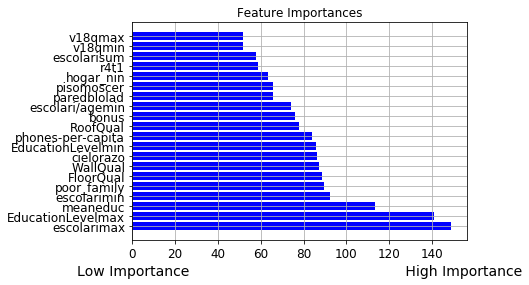

In [185]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(Topfea)[:, 1]
sortedImportances = np.array(Topfea)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Low Importance                                                High Importance')
plt.grid()
plt.show()

In [186]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

# Full Pipeline

In [187]:
# Union the transformed, scaled numeric and categorical features.
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

# Full Pipeline with predictor

In [189]:
k=11
featureScores = feature_importances[["F Score"]].values.flatten()


In [190]:
# use full pipeline above to build full pipeline with predictor
from sklearn.feature_selection import SelectKBest
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("feat", TopFeatureSelector(featureScores, k)),
        ("lr", LogisticRegression())
    ])

# Phase1 Baseline Model

In [240]:
X_train.shape

(2378, 212)

In [241]:
start = time()
full_pipeline_with_predictor.fit(X_train, y_train)

# Time and score training predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
logit_scores = cross_val_score(full_pipeline_with_predictor, X_train, y_train, cv=cv)
logit_score_train = logit_scores.mean()
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
logit_score_test  = full_pipeline_with_predictor.score(X_test, y_test)
test_time = np.round(time() - start, 4)

In [242]:
results.loc[len(results)] = ["Baseline", pct(logit_score_train), pct(logit_score_test), 
                  "---", train_time, test_time, "Untuned LogisticRegression"]
results

,ExpID,Train Accuracy (Mean),Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,66.7,66.1,---,3.6269,0.0149,Untuned LogisticRegression


# Phase1 - Conduct Grid Search using a variety of Classification Algorithms

In [243]:

# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix=''):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(random_state=42)),
        ('RandomForest', RandomForestClassifier()),
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'C': (10, 1, 0.1, 0.01),
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2),
        },
        'Naive Bayes': {},
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': (1, 2, 3, 4, 5),
            'C': (10, 1, 0.1, 0.01),
        },
        'Stochastic GD': {
            'loss': ('hinge', 'perceptron', 'log'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'alpha': (0.1, 0.01, 0.001, 0.0001), 
        },
        'RandomForest':  {
            'max_depth': [9, 15, 22, 26, 30],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[20, 80, 150, 200, 300]},
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("feat", SelectKBest(k='all')),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
            
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv)
        best_train_accuracy = pct(best_train_scores.mean())

        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, round(p_value,3), train_time, test_time, json.dumps(param_dump)]

In [244]:
%%time
# This might take a while
ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:")

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 17.7min finished


Best Parameters:
	predictor__C: 0.01
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Logistic Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (3, 5, 7, 8, 11)
	p: (1, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.6min finished


Best Parameters:
	predictor__n_neighbors: 11
	predictor__p: 2
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Naive Bayes *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Best Parameters:
****** FINISH Best Model: Naive Bayes  *****

****** START Best Model: Support Vector *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	degree: (1, 2, 3, 4, 5)
	kernel: ('rbf', 'poly')
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.0min finished


Best Parameters:
	predictor__C: 10
	predictor__degree: 1
	predictor__kernel: poly
****** FINISH Best Model: Support Vector  *****

****** START Best Model: Stochastic GD *****
Parameters:
	alpha: (0.1, 0.01, 0.001, 0.0001)
	loss: ('hinge', 'perceptron', 'log')
	penalty: ('l1', 'l2', 'elasticnet')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  5.2min finished


Best Parameters:
	predictor__alpha: 0.1
	predictor__loss: log
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Stochastic GD  *****

****** START Best Model: RandomForest *****
Parameters:
	bootstrap: [False]
	max_depth: [9, 15, 22, 26, 30]
	max_features: [1, 3, 5]
	min_samples_leaf: [3, 5, 10]
	min_samples_split: [5, 10, 15]
	n_estimators: [20, 80, 150, 200, 300]
Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=1)]: Done 3375 out of 3375 | elapsed: 27.6min finished


Best Parameters:
	predictor__bootstrap: False
	predictor__max_depth: 15
	predictor__max_features: 5
	predictor__min_samples_leaf: 3
	predictor__min_samples_split: 10
	predictor__n_estimators: 200
****** FINISH Best Model: RandomForest  *****

CPU times: user 1h 27min 38s, sys: 1min 56s, total: 1h 29min 35s
Wall time: 1h 6min 13s


In [246]:
results

,ExpID,Train Accuracy (Mean),Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,66.7,66.1,---,3.6269,0.0149,Untuned LogisticRegression
1,Best Model:Logistic Regression,67.7,68.7,0,0.5882,0.0105,"[[""predictor__C"", 0.01], [""predictor__penalty""..."
2,Best Model:K-Nearest Neighbors,66.5,64.7,0.633,0.1542,1.1371,"[[""predictor__n_neighbors"", 11], [""predictor__..."
3,Best Model:Naive Bayes,19.6,19.2,0,0.0986,0.0194,[]
4,Best Model:Support Vector,67.4,67.2,0.002,2.4390,0.3861,"[[""predictor__C"", 10], [""predictor__degree"", 1..."
5,Best Model:Stochastic GD,67.8,68.2,0,0.2796,0.0105,"[[""predictor__alpha"", 0.1], [""predictor__loss""..."
6,Best Model:RandomForest,67.4,67.4,0,0.7504,0.0627,"[[""predictor__bootstrap"", false], [""predictor_..."


# Phase1 - Results

- Downloaded the data and did exploratory data analysis
- Filled in few NaN values using appropriate strategies based on the feature type and description as part of pre-processing the dataset
- Dropped and added few of the features as part of feature engineering
- Imputed pending NaN values using the appropriate strategy in pipeline
- Created different data preparation pipelines for treating numerical and categorical features
- Model generation is using the full pipeline with estimator
- Created baseline model - logistic regression untuned version
- Built classification models, KNN, NB, SVM, SGDC and RandomForest with hyperparameter tuning via Gridsearch
- Compared the tuned models with the baseline models using t-tests and the respective p-values are displayed in the results table
- As per teh p-values, KNN perform almost similar to the basemodel and rest all models are doing a better job.
- We compared the model using accuracy. Considered only best 20 features at this stage. The accuracy score is around 67 which is not that great

- In **Phase2**, We are planning to look for more feature engineering options to get a better prepared dataset to go into the models
- Also a more experiments and analysis on the feature importance and feature selection part so that we can build more accurate optimal model.

# Phase2 - Baseline model after additional feature 

In [206]:
# use full pipeline above to build full pipeline with predictor
from sklearn.feature_selection import SelectKBest
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("feat", SelectKBest(k=20)),
        ("lr", LogisticRegression())
    ])

In [207]:
X_train.shape

(2378, 243)

In [208]:
start = time()
full_pipeline_with_predictor.fit(X_train, y_train)

# Time and score training predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
logit_scores = cross_val_score(full_pipeline_with_predictor, X_train, y_train, cv=cv)
logit_score_train = logit_scores.mean()
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
logit_score_test  = full_pipeline_with_predictor.score(X_test, y_test)
test_time = np.round(time() - start, 4)

In [209]:
results.loc[len(results)] = ["Baseline", pct(logit_score_train), pct(logit_score_test), 
                  "---", train_time, test_time, "Untuned LogisticRegression"]
results

,ExpID,Train Accuracy (Mean),Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,66.5,66.2,---,3.7568,0.0565,Untuned LogisticRegression
1,Best Model:Logistic Regression,67.8,67.6,0,0.6545,0.0106,"[[""predictor__C"", 0.01], [""predictor__penalty""..."
2,Best Model:K-Nearest Neighbors,66.1,64.0,0.129,0.1443,1.1021,"[[""predictor__n_neighbors"", 11], [""predictor__..."
3,Best Model:Naive Bayes,17.6,15.3,0,0.1342,0.0208,[]
4,Best Model:Support Vector,67.2,69.2,0.001,2.4806,0.4176,"[[""predictor__C"", 10], [""predictor__degree"", 1..."
5,Best Model:Stochastic GD,67.4,67.7,0,0.2500,0.0125,"[[""predictor__alpha"", 0.1], [""predictor__loss""..."
6,Best Model:RandomForest,67.2,67.4,0,0.3761,0.0247,"[[""predictor__bootstrap"", false], [""predictor_..."
7,Baseline,66.5,66.2,---,4.0414,0.0089,Untuned LogisticRegression


Data for training and test split from the train_set

X_train
y_train
X_test
y_test

# Phase2 - Conduct Grid Search using a variety of Classification Algorithms

In [202]:

# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix=''):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(random_state=42)),
        ('RandomForest', RandomForestClassifier()),
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'C': (10, 1, 0.1, 0.01),
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2),
        },
        'Naive Bayes': {},
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': (1, 2, 3, 4, 5),
            'C': (10, 1, 0.1, 0.01),
        },
        'Stochastic GD': {
            'loss': ('hinge', 'perceptron', 'log'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'alpha': (0.1, 0.01, 0.001, 0.0001), 
        },
        'RandomForest':  {
            'max_depth': [9, 15, 22, 26, 30],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[20, 80, 150, 200, 300]},
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("feat", SelectKBest(k='all')),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
            
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv)
        best_train_accuracy = pct(best_train_scores.mean())

        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, round(p_value,3), train_time, test_time, json.dumps(param_dump)]

In [201]:
%%time
# This might take a while
ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:")

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 17.3min finished


Best Parameters:
	predictor__C: 0.01
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Logistic Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (3, 5, 7, 8, 11)
	p: (1, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.6min finished


Best Parameters:
	predictor__n_neighbors: 11
	predictor__p: 1
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Naive Bayes *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Best Parameters:
****** FINISH Best Model: Naive Bayes  *****

****** START Best Model: Support Vector *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	degree: (1, 2, 3, 4, 5)
	kernel: ('rbf', 'poly')
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 10.7min finished


Best Parameters:
	predictor__C: 10
	predictor__degree: 1
	predictor__kernel: poly
****** FINISH Best Model: Support Vector  *****

****** START Best Model: Stochastic GD *****
Parameters:
	alpha: (0.1, 0.01, 0.001, 0.0001)
	loss: ('hinge', 'perceptron', 'log')
	penalty: ('l1', 'l2', 'elasticnet')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  4.3min finished


Best Parameters:
	predictor__alpha: 0.1
	predictor__loss: hinge
	predictor__penalty: l2
	predictor__tol: 1e-05
****** FINISH Best Model: Stochastic GD  *****

****** START Best Model: RandomForest *****
Parameters:
	bootstrap: [False]
	max_depth: [9, 15, 22, 26, 30]
	max_features: [1, 3, 5]
	min_samples_leaf: [3, 5, 10]
	min_samples_split: [5, 10, 15]
	n_estimators: [20, 80, 150, 200, 300]
Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=1)]: Done 3375 out of 3375 | elapsed: 27.6min finished


Best Parameters:
	predictor__bootstrap: False
	predictor__max_depth: 22
	predictor__max_features: 5
	predictor__min_samples_leaf: 3
	predictor__min_samples_split: 10
	predictor__n_estimators: 20
****** FINISH Best Model: RandomForest  *****

CPU times: user 1h 25min 27s, sys: 1min 53s, total: 1h 27min 20s
Wall time: 1h 4min 24s


In [203]:
results

,ExpID,Train Accuracy (Mean),Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,66.5,66.2,---,3.7568,0.0565,Untuned LogisticRegression
1,Best Model:Logistic Regression,67.8,67.6,0,0.6427,0.0100,"[[""predictor__C"", 0.01], [""predictor__penalty""..."
2,Best Model:K-Nearest Neighbors,66.1,64.0,0.129,0.1602,1.0975,"[[""predictor__n_neighbors"", 11], [""predictor__..."
3,Best Model:Naive Bayes,17.6,15.3,0,0.0998,0.0215,[]
4,Best Model:Support Vector,67.2,69.2,0.001,2.4378,0.3771,"[[""predictor__C"", 10], [""predictor__degree"", 1..."
5,Best Model:Stochastic GD,67.4,67.7,0,0.2405,0.0098,"[[""predictor__alpha"", 0.1], [""predictor__loss""..."
6,Best Model:RandomForest,67.0,66.1,0.001,0.1727,0.0141,"[[""predictor__bootstrap"", false], [""predictor_..."


In [213]:
# With top 20 features


# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix=''):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(random_state=42)),
        ('RandomForest', RandomForestClassifier()),
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'C': (10, 1, 0.1, 0.01),
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2),
        },
        'Naive Bayes': {},
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': (1, 2, 3, 4, 5),
            'C': (10, 1, 0.1, 0.01),
        },
        'Stochastic GD': {
            'loss': ('hinge', 'perceptron', 'log'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'alpha': (0.1, 0.01, 0.001, 0.0001), 
        },
        'RandomForest':  {
            'max_depth': [9, 15, 22, 26, 30],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[20, 80, 150, 200, 300]},
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("feat", SelectKBest(k=20)),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
            
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv)
        best_train_accuracy = pct(best_train_scores.mean())

        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, round(p_value,3), train_time, test_time, json.dumps(param_dump)]

In [214]:
%%time
# This might take a while
ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:")

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   36.8s finished


Best Parameters:
	predictor__C: 0.01
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Logistic Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (3, 5, 7, 8, 11)
	p: (1, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.0s finished


Best Parameters:
	predictor__n_neighbors: 11
	predictor__p: 1
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Naive Bayes *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Best Parameters:
****** FINISH Best Model: Naive Bayes  *****

****** START Best Model: Support Vector *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	degree: (1, 2, 3, 4, 5)
	kernel: ('rbf', 'poly')
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.2min finished


Best Parameters:
	predictor__C: 1
	predictor__degree: 2
	predictor__kernel: poly
****** FINISH Best Model: Support Vector  *****

****** START Best Model: Stochastic GD *****
Parameters:
	alpha: (0.1, 0.01, 0.001, 0.0001)
	loss: ('hinge', 'perceptron', 'log')
	penalty: ('l1', 'l2', 'elasticnet')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  1.0min finished


Best Parameters:
	predictor__alpha: 0.01
	predictor__loss: log
	predictor__penalty: l1
	predictor__tol: 0.0001
****** FINISH Best Model: Stochastic GD  *****

****** START Best Model: RandomForest *****
Parameters:
	bootstrap: [False]
	max_depth: [9, 15, 22, 26, 30]
	max_features: [1, 3, 5]
	min_samples_leaf: [3, 5, 10]
	min_samples_split: [5, 10, 15]
	n_estimators: [20, 80, 150, 200, 300]
Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=1)]: Done 3375 out of 3375 | elapsed: 30.6min finished


Best Parameters:
	predictor__bootstrap: False
	predictor__max_depth: 9
	predictor__max_features: 3
	predictor__min_samples_leaf: 10
	predictor__min_samples_split: 15
	predictor__n_estimators: 20
****** FINISH Best Model: RandomForest  *****

CPU times: user 52min 36s, sys: 1min 36s, total: 54min 13s
Wall time: 34min


In [215]:
results

,ExpID,Train Accuracy (Mean),Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,66.5,66.2,---,3.7568,0.0565,Untuned LogisticRegression
1,Best Model:Logistic Regression,66.9,67.1,0.001,0.1087,0.0121,"[[""predictor__C"", 0.01], [""predictor__penalty""..."
2,Best Model:K-Nearest Neighbors,64.4,63.0,0,0.0764,0.0486,"[[""predictor__n_neighbors"", 11], [""predictor__..."
3,Best Model:Naive Bayes,56.8,56.5,0,0.0763,0.0094,[]
4,Best Model:Support Vector,66.5,66.4,0.789,0.3461,0.0297,"[[""predictor__C"", 1], [""predictor__degree"", 2]..."
5,Best Model:Stochastic GD,66.4,66.1,0.65,0.0907,0.0090,"[[""predictor__alpha"", 0.01], [""predictor__loss..."
6,Best Model:RandomForest,66.4,67.6,0.756,0.1525,0.0158,"[[""predictor__bootstrap"", false], [""predictor_..."
7,Baseline,66.5,66.2,---,4.0414,0.0089,Untuned LogisticRegression


# GBDT Classifier

In [191]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
k=20
full_pipeline_with_predictor_GBDT = Pipeline([
        ("preparation", full_pipeline),
        ("feat", TopFeatureSelector(featureScores, k)),
        ("gbdt", GradientBoostingClassifier())
    ])



In [223]:
parameters = {
    "gbdt__loss":["deviance"],
    "gbdt__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "gbdt__min_samples_split": np.linspace(0.1, 0.5, 12),
    "gbdt__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "gbdt__max_depth":[3,5,8],
    "gbdt__max_features":["log2","sqrt"],
    "gbdt__criterion": ["friedman_mse",  "mae"],
    "gbdt__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "gbdt__n_estimators":[10]
    }



In [224]:
clf = GridSearchCV(full_pipeline_with_predictor_GBDT, parameters, cv=10, n_jobs=-1)


In [192]:
full_pipeline_with_predictor_GBDT.fit(X_train, y_train)
#print(clf.score(trainX, trainY))
#print(clf.best_params_)

Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['v2a1', 'dependency', 'meaneduc', 'overcrowding', 'poor_family', 'phones-per-capita', 'tablets-per-capita', 'rooms-per-capita', 'r...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [194]:
train_pred = full_pipeline_with_predictor_GBDT.predict(X_test)

In [196]:
full_pipeline_with_predictor_GBDT.named_steps['gbdt'].feature_importances_

array([0.06522472, 0.17278068, 0.37066326, 0.01778017, 0.01848402,
       0.01470491, 0.01631572, 0.01450181, 0.01226492, 0.01680463,
       0.09180882, 0.05077121, 0.01840595, 0.01911106, 0.03340846,
       0.0061793 , 0.01618491, 0.01322061, 0.00906445, 0.02232038])